# Assignment B - Networked Nations

This notebook ...

## Table of Contents

1. [Setup and Initialization](#1.-Setup-and-Initialization)
2. [Network Overview and Statistics](#2.-Network-Overview-and-Statistics)
3. [Network Topology Analysis](#3.-Network-Topology-Analysis)
4. [Node Importance and Centrality](#4.-Node-Importance-and-Centrality)
5. [Network Mixing Patterns](#5.-Network-Mixing-Patterns)
6. [Community Detection](#6.-Community-Detection)
10. [Conclusions and Summary](#10.-Conclusions-and-Summary)


## Analysis Overview

This analysis employs a comprehensive set of network science techniques:

- **Basic Statistics**: Nodes, edges, density, path lengths, clustering coefficients
- **Visualization**: ForceAtlas2 layout to reveal network structure
- **Degree Distribution**: Power-law analysis to identify scale-free properties
- **Centrality Measures**: Degree, betweenness, and eigenvector centrality
- **Topology Analysis**: Assortativity and mixing patterns
- **Community Detection**: Identify natural groupings and diplomatic blocs

## 1. Setup and Initialization

### 1.1 Import Libraries and Load Data

In [415]:
# imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community import louvain_communities
import json
import re
from collections import defaultdict, Counter
import random
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import networkx as nx
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statistics as stats
import plotly.express as px
import seaborn as sns
import matplotlib.ticker as ticker
import powerlaw
from networkx.algorithms.community import louvain_communities
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import io 
import urllib.request


# setting a random seed for reproductability
random.seed(42)

# Load the graphs
G_embassy = nx.read_gexf('/Users/smilladue/Desktop/Documents/DTU/social-graphs/IP_graph/foreign_relations_table_based_embassy_only.gexf')
G_alliance = nx.read_gexf('/Users/smilladue/Desktop/Documents/DTU/social-graphs/IP_graph/foreign_relations_table_based_with_alliance.gexf')


### 1.2 Helper Functions

This section defines utility functions for network analysis and visualization.

In [416]:
def basic_network_statistics(G, graph_name="Graph"):
    """
    Calculate basic network statistics for a graph.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph to analyze
    graph_name : str
        Name of the graph for identification
        
    Returns:
    --------
    dict : Dictionary containing all statistics
    """
    stats = {}
    stats['Graph Name'] = graph_name
    
    # Basic metrics
    stats['Number of Nodes'] = G.number_of_nodes()
    stats['Number of Edges'] = G.number_of_edges()
    
    # Degree statistics
    degrees = dict(G.degree())
    stats['Min Degree'] = min(degrees.values()) if degrees else 0
    stats['Max Degree'] = max(degrees.values()) if degrees else 0
    stats['Average Degree'] = sum(degrees.values()) / len(degrees) if degrees else 0
    
    # Density
    stats['Density'] = nx.density(G)
    
    # Connectivity metrics (only if graph is connected)
    if nx.is_connected(G):
        stats['Average Shortest Path'] = nx.average_shortest_path_length(G)
        stats['Diameter'] = nx.diameter(G)
    else:
        # For disconnected graphs, use largest component
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc)
        stats['Average Shortest Path'] = nx.average_shortest_path_length(G_largest)
        stats['Diameter'] = nx.diameter(G_largest)
        stats['Number of Components'] = nx.number_connected_components(G)
    
    # Clustering
    stats['Average Clustering Coefficient'] = nx.average_clustering(G)
    
    return stats


def compare_graphs_table(graphs_dict):
    """
    Create a comparison table for multiple graphs.
    
    Parameters:
    -----------
    graphs_dict : dict
        Dictionary with graph names as keys and networkx graphs as values
        
    Returns:
    --------
    pd.DataFrame : DataFrame with statistics for all graphs
    """
    all_stats = []
    
    for name, graph in graphs_dict.items():
        stats = basic_network_statistics(graph, name)
        all_stats.append(stats)
    
    df = pd.DataFrame(all_stats)
    df = df.set_index('Graph Name')
    
    return df

In [417]:
def plot_degree_distribution(G, graph_name="Graph", bins=50):
    """
    Plot degree distribution in both linear and log-log scale.
    """
    degrees = [d for n, d in G.degree()]
    counts, bin_edges = np.histogram(degrees, bins=bins)  
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Filter out zero counts for log-log plot
    mask = counts > 0
    bin_centers_filtered = bin_centers[mask]
    counts_filtered = counts[mask]
    
    plt.style.use("seaborn-v0_8-whitegrid") 
    accent_color = "skyblue"
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Linear scale
    ax1.plot(bin_centers, counts, marker="o", markersize=6, linestyle="None", 
             color=accent_color, label="Degree distribution")
    ax1.set_xlabel("Degree", fontsize=12)
    ax1.set_ylabel("Number of nodes", fontsize=12)
    ax1.set_title(f"{graph_name} - Linear Scale", fontsize=13, weight="bold")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Log-log scale
    ax2.loglog(bin_centers_filtered, counts_filtered, marker="o", markersize=6,
               linestyle="None", color=accent_color, label="Degree distribution")
    ax2.set_xlabel("Degree (log scale)", fontsize=12)
    ax2.set_ylabel("Number of nodes (log scale)", fontsize=12)
    ax2.set_title(f"{graph_name} - Log-Log Scale", fontsize=13, weight="bold")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.7)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


def degree_stats(G):
    """
    Calculate key statistics for degree distribution.
    """
    degrees = [d for n, d in G.degree()]
    return {
        'mean': np.mean(degrees),
        'median': np.median(degrees),
        'min': min(degrees),
        'max': max(degrees),
        'std': np.std(degrees)
    }


def get_top_nodes(G, n=5, by='degree'):
    """Get top n nodes by specified metric."""
    if by == 'in_degree':
        ranking = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:n]
    elif by == 'out_degree':
        ranking = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:n]
    else:  # degree
        ranking = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:n]
    return ranking


def visualize_network(G, graph_name="Graph", node_attribute=None, node_size_multiplier=1.2):
    """
    Visualize network using ForceAtlas2-style layout.
    Node size based on degree, single color for now.
    For disconnected graphs we still use ForceAtlas2 but then rescale so
    the drawing fills the figure.
    """
    # Node sizes by degree
    degrees = dict(G.degree())
    node_sizes = [degrees[n] * node_size_multiplier for n in G.nodes()]
    
    # Simple color scheme - no attribute coloring for now
    node_colors = 'purple'
    
    # Layout graph for ForceAtlas2
    if nx.is_connected(G):
        G_layout = G
    else:
        G_layout = G.copy()
        components = list(nx.connected_components(G_layout))
        reps = [next(iter(c)) for c in components]
        for i in range(len(reps) - 1):
            if not G_layout.has_edge(reps[i], reps[i+1]):
                G_layout.add_edge(reps[i], reps[i+1], weight=1e-6)
    
    pos = nx.forceatlas2_layout(
        G_layout,
        max_iter=2000,
        scaling_ratio=20.0,
        gravity=1.2,
        linlog=True,
        dissuade_hubs=False
    )

    # Rescale positions per-graph so they fill the canvas
    xs = np.array([p[0] for p in pos.values()])
    ys = np.array([p[1] for p in pos.values()])
    x_range = xs.max() - xs.min() if xs.max() != xs.min() else 1.0
    y_range = ys.max() - ys.min() if ys.max() != ys.min() else 1.0

    for node, (x, y) in list(pos.items()):
        nx_ = ((x - xs.min()) / x_range - 0.5) * 2.0   # [-1, 1]
        ny_ = ((y - ys.min()) / y_range - 0.5) * 2.0
        pos[node] = np.array([nx_, ny_])
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                           alpha=0.9, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.25, width=0.3, edge_color="#999999", ax=ax)
    
    ax.set_axis_off()
    ax.set_title(f"{graph_name}", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


def calculate_centralities(G):
    """
    Calculate multiple centrality measures for the network.
    Returns a DataFrame with all centrality scores.
    """
    centralities = pd.DataFrame(index=G.nodes())
    
    # Degree centrality
    centralities['degree'] = pd.Series(dict(G.degree()))
    centralities['degree_centrality'] = pd.Series(nx.degree_centrality(G))
    
    # Betweenness centrality
    centralities['betweenness'] = pd.Series(nx.betweenness_centrality(G, weight=None))
    
    # Eigenvector centrality (handle disconnected graphs)
    try:
        centralities['eigenvector'] = pd.Series(nx.eigenvector_centrality(G, max_iter=1000))
    except:
        centralities['eigenvector'] = 0
    
    # Weighted versions if graph has weights
    if nx.is_weighted(G):
        centralities['betweenness_weighted'] = pd.Series(
            nx.betweenness_centrality(G, weight='weight'))
    
    return centralities

In [418]:
def visualize_community_comparison(G, graph_name, country_to_continent, resolution=1):
    """
    Visualize and compare Louvain communities vs continent-based communities.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph to analyze
    graph_name : str
        Name of the graph for plot titles
    country_to_continent : dict
        Mapping of country names to continents
    resolution : float
        Resolution parameter for Louvain algorithm
    """
    # Get nodes with continent data
    nodes_with_continent = [n for n in G.nodes() if n in country_to_continent]
    G_continents = G.subgraph(nodes_with_continent).copy()
    
    # Get communities
    node_to_continent = {n: country_to_continent[n] for n in G_continents.nodes()}
    louvain_comms = louvain_communities(G_continents, weight='weight', resolution=resolution, seed=42)
    louvain_sorted = sorted(louvain_comms, key=len, reverse=True)
    
    # Create node index mapping
    node_index_map = {node: idx for idx, node in enumerate(G_continents.nodes())}
    
    # === LOUVAIN COLORING ===
    node_colors_louvain = np.full(len(G_continents), -1, dtype=int)
    for i, community in enumerate(louvain_sorted):
        for node in community:
            if node in node_index_map:
                node_colors_louvain[node_index_map[node]] = i
    
    num_louvain_comms = len(louvain_sorted)
    cmap_louvain = matplotlib.colormaps['tab10'].resampled(num_louvain_comms)
    louvain_colors = [cmap_louvain(c) if c >= 0 else '#cccccc' for c in node_colors_louvain]
    
    # === CONTINENT COLORING ===
    unique_continents = sorted(set(node_to_continent.values()))
    continent_to_idx = {cont: i for i, cont in enumerate(unique_continents)}
    node_colors_continent = np.array([continent_to_idx[node_to_continent[n]] 
                                     for n in G_continents.nodes()])
    cmap_continent = matplotlib.colormaps['Set3'].resampled(len(unique_continents))
    continent_colors = [cmap_continent(c) for c in node_colors_continent]
    
    # === LAYOUT ===
    if nx.is_connected(G_continents):
        G_layout = G_continents
    else:
        G_layout = G_continents.copy()
        components = list(nx.connected_components(G_layout))
        reps = [next(iter(c)) for c in components]
        for i in range(len(reps) - 1):
            if not G_layout.has_edge(reps[i], reps[i+1]):
                G_layout.add_edge(reps[i], reps[i+1], weight=1e-6)
    
    pos = nx.forceatlas2_layout(
        G_layout, max_iter=2000, scaling_ratio=20.0, 
        gravity=0.8, linlog=True, dissuade_hubs=False
    )
    
    # Node sizes by degree
    degrees = dict(G_continents.degree())
    node_sizes = [degrees[n] * 3 for n in G_continents.nodes()]
    
    # === PLOTTING ===
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))
    
    # 1. Louvain communities
    nx.draw_networkx_nodes(
        G_continents, pos, ax=axes[0], node_color=louvain_colors,
        node_size=node_sizes, alpha=0.9
    )
    nx.draw_networkx_edges(G_continents, pos, alpha=0.15, width=0.3, 
                          edge_color="#999999", ax=axes[0])
    axes[0].set_title("Louvain Communities", fontsize=14, weight='bold')
    axes[0].axis('off')
    
    # Legend for Louvain
    legend_elements_louvain = [
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=cmap_louvain(i), markersize=10,
                  label=f"Community {i+1} (n={len(louvain_sorted[i])})")
        for i in range(min(7, len(louvain_sorted)))
    ]
    axes[0].legend(handles=legend_elements_louvain, loc='upper left', 
                  frameon=True, fontsize=9)
    
    # 2. Continent communities
    nx.draw_networkx_nodes(
        G_continents, pos, ax=axes[1], node_color=continent_colors,
        node_size=node_sizes, alpha=0.9
    )
    nx.draw_networkx_edges(G_continents, pos, alpha=0.15, width=0.3,
                          edge_color="#999999", ax=axes[1])
    axes[1].set_title("Continent-Based Communities", fontsize=14, weight='bold')
    axes[1].axis('off')
    
    # Legend for continents
    legend_elements_continent = [
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor=cmap_continent(i), markersize=10,
                  label=f"{cont} (n={sum(1 for n in G_continents.nodes() if node_to_continent[n] == cont)})")
        for i, cont in enumerate(unique_continents)
    ]
    axes[1].legend(handles=legend_elements_continent, loc='upper left',
                  frameon=True, fontsize=9)
    
    plt.suptitle(f"{graph_name}\nCommunity Detection Comparison", 
                fontsize=16, weight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

In [419]:
def get_country_continent_mapping(G):
    """
    Returns a dictionary mapping country names to continents.
    Includes all ~195 countries with common name variations (spaces, underscores, "the" prefix).
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph containing country nodes (used to check for missing mappings)
        
    Returns:
    --------
    dict : Mapping of country names to continent names
    """
    # Base mapping with underscores (original format)
    base_mapping = {
        # Africa (54 countries)
        'Algeria': 'Africa', 'Angola': 'Africa', 'Benin': 'Africa', 'Botswana': 'Africa',
        'Burkina_Faso': 'Africa', 'Burundi': 'Africa', 'Cameroon': 'Africa', 'Cape_Verde': 'Africa',
        'Central_African_Republic': 'Africa', 'Chad': 'Africa', 'Comoros': 'Africa', 
        'Democratic_Republic_of_the_Congo': 'Africa', 'Republic_of_the_Congo': 'Africa', 'Congo': 'Africa',
        'Djibouti': 'Africa', 'Egypt': 'Africa', 'Equatorial_Guinea': 'Africa',
        'Eritrea': 'Africa', 'Eswatini': 'Africa', 'Ethiopia': 'Africa', 'Gabon': 'Africa',
        'Gambia': 'Africa', 'Ghana': 'Africa', 'Guinea': 'Africa', 'Guinea-Bissau': 'Africa',
        'Ivory_Coast': 'Africa', "Cote_d'Ivoire": 'Africa', 'Kenya': 'Africa', 'Lesotho': 'Africa', 
        'Liberia': 'Africa', 'Libya': 'Africa', 'Madagascar': 'Africa', 'Malawi': 'Africa', 
        'Mali': 'Africa', 'Mauritania': 'Africa', 'Mauritius': 'Africa', 'Morocco': 'Africa', 
        'Mozambique': 'Africa', 'Namibia': 'Africa', 'Niger': 'Africa', 'Nigeria': 'Africa', 
        'Rwanda': 'Africa', 'Sao_Tome_and_Principe': 'Africa', 'Senegal': 'Africa', 
        'Seychelles': 'Africa', 'Sierra_Leone': 'Africa', 'Somalia': 'Africa', 'South_Africa': 'Africa', 
        'South_Sudan': 'Africa', 'Sudan': 'Africa', 'Tanzania': 'Africa', 'Togo': 'Africa', 
        'Tunisia': 'Africa', 'Uganda': 'Africa', 'Zambia': 'Africa', 'Zimbabwe': 'Africa',
        
        # Asia (48 countries)
        'Afghanistan': 'Asia', 'Armenia': 'Asia', 'Azerbaijan': 'Asia', 'Bahrain': 'Asia',
        'Bangladesh': 'Asia', 'Bhutan': 'Asia', 'Brunei': 'Asia', 'Cambodia': 'Asia',
        'China': 'Asia', 'Cyprus': 'Asia', 'Georgia': 'Asia', 'India': 'Asia',
        'Indonesia': 'Asia', 'Iran': 'Asia', 'Iraq': 'Asia', 'Israel': 'Asia',
        'Japan': 'Asia', 'Jordan': 'Asia', 'Kazakhstan': 'Asia', 'Kuwait': 'Asia',
        'Kyrgyzstan': 'Asia', 'Laos': 'Asia', 'Lebanon': 'Asia', 'Malaysia': 'Asia',
        'Maldives': 'Asia', 'Mongolia': 'Asia', 'Myanmar': 'Asia', 'Nepal': 'Asia',
        'North_Korea': 'Asia', 'Oman': 'Asia', 'Pakistan': 'Asia', 'Palestine': 'Asia',
        'Philippines': 'Asia', 'Qatar': 'Asia', 'Saudi_Arabia': 'Asia', 'Singapore': 'Asia',
        'South_Korea': 'Asia', 'Sri_Lanka': 'Asia', 'Syria': 'Asia', 'Tajikistan': 'Asia',
        'Thailand': 'Asia', 'Timor-Leste': 'Asia', 'East_Timor': 'Asia', 'Turkey': 'Asia', 'Taiwan': 'Asia',
        'Turkmenistan': 'Asia', 'United_Arab_Emirates': 'Asia', 'Uzbekistan': 'Asia', 
        'Vietnam': 'Asia', 'Yemen': 'Asia',
        
        # Europe (44 countries)
        'Albania': 'Europe', 'Andorra': 'Europe', 'Austria': 'Europe', 'Belarus': 'Europe',
        'Belgium': 'Europe', 'Bosnia_and_Herzegovina': 'Europe', 'Bulgaria': 'Europe', 
        'Croatia': 'Europe', 'Czech_Republic': 'Europe', 'Denmark': 'Europe', 'Estonia': 'Europe', 
        'Finland': 'Europe', 'France': 'Europe', 'Germany': 'Europe', 'Greece': 'Europe', 
        'Hungary': 'Europe', 'Iceland': 'Europe', 'Ireland': 'Europe', 'Italy': 'Europe', 
        'Kosovo': 'Europe', 'Latvia': 'Europe', 'Liechtenstein': 'Europe', 'Lithuania': 'Europe', 
        'Luxembourg': 'Europe', 'Malta': 'Europe', 'Moldova': 'Europe', 'Monaco': 'Europe', 
        'Montenegro': 'Europe', 'Netherlands': 'Europe', 'North_Macedonia': 'Europe', 
        'Macedonia': 'Europe', 'Norway': 'Europe', 'Poland': 'Europe', 'Portugal': 'Europe', 
        'Romania': 'Europe', 'Russia': 'Europe', 'San_Marino': 'Europe', 'Serbia': 'Europe', 
        'Slovakia': 'Europe', 'Slovenia': 'Europe', 'Spain': 'Europe', 'Sweden': 'Europe', 
        'Switzerland': 'Europe', 'Ukraine': 'Europe', 'United_Kingdom': 'Europe', 
        'Vatican_City': 'Europe',
        
        # North America (23 countries)
        'Antigua_and_Barbuda': 'North America', 'Bahamas': 'North America', 'Barbados': 'North America', 
        'Belize': 'North America', 'Canada': 'North America', 'Costa_Rica': 'North America', 
        'Cuba': 'North America', 'Dominica': 'North America', 'Dominican_Republic': 'North America', 
        'El_Salvador': 'North America', 'Grenada': 'North America', 'Guatemala': 'North America',
        'Haiti': 'North America', 'Honduras': 'North America', 'Jamaica': 'North America', 
        'Mexico': 'North America', 'Nicaragua': 'North America', 'Panama': 'North America', 
        'Saint_Kitts_and_Nevis': 'North America', 'Saint_Lucia': 'North America',
        'Saint_Vincent_and_the_Grenadines': 'North America', 'Trinidad_and_Tobago': 'North America', 
        'United_States': 'North America',
        
        # South America (12 countries)
        'Argentina': 'South America', 'Bolivia': 'South America', 'Brazil': 'South America', 
        'Chile': 'South America', 'Colombia': 'South America', 'Ecuador': 'South America', 
        'Guyana': 'South America', 'Paraguay': 'South America', 'Peru': 'South America', 
        'Suriname': 'South America', 'Uruguay': 'South America', 'Venezuela': 'South America',
        
        # Oceania (14 countries)
        'Australia': 'Oceania', 'Fiji': 'Oceania', 'Kiribati': 'Oceania', 'Marshall_Islands': 'Oceania',
        'Micronesia': 'Oceania', 'Nauru': 'Oceania', 'New_Zealand': 'Oceania', 'Palau': 'Oceania',
        'Papua_New_Guinea': 'Oceania', 'Samoa': 'Oceania', 'Solomon_Islands': 'Oceania', 
        'Tonga': 'Oceania', 'Tuvalu': 'Oceania', 'Vanuatu': 'Oceania'
    }
    
    # Create comprehensive mapping with all variations
    mapping = base_mapping.copy()
    
    # Add space-separated versions of all underscore names
    for country, continent in base_mapping.items():
        if '_' in country:
            space_version = country.replace('_', ' ')
            mapping[space_version] = continent
    
    # Add "the" prefix versions for countries that commonly use it
    the_countries = ['United States', 'United Kingdom', 'Gambia', 'Marshall Islands', 
                     'Netherlands', 'Philippines', 'Bahamas', 'Central African Republic',
                     'Democratic Republic of the Congo', 'Republic of the Congo', 'Congo',
                     'Dominican Republic', 'Solomon Islands', 'Maldives', 'Comoros',
                     'Czech Republic', 'Vatican City', 'United Arab Emirates']
    for country in the_countries:
        if country in mapping:
            mapping[f'the {country}'] = mapping[country]
    
    # Add special cases with unique formatting
    mapping['São Tomé and Príncipe'] = 'Africa'  # Portuguese special characters
    mapping['the Federated States of Micronesia'] = 'Oceania'  # Full formal name
    
    # Check which countries in the graph are missing from the mapping
    missing = [n for n in G.nodes() if n not in mapping]
    if missing:
        print(f"WARNING: {len(missing)} countries not in continent mapping:")
        print(f"  {missing[:10]}{'...' if len(missing) > 10 else ''}")
    
    return mapping


def calculate_modularity(G, node_to_community):
    """
    Calculate Newman-Girvan modularity for given community assignments.
    Adapted from Assignment 2 approach.
    
    Parameters:
    -----------
    G : networkx.Graph
        The network
    node_to_community : dict
        Mapping of node -> community label
    
    Returns:
    --------
    float : Modularity score (between -1 and 1)
    """
    from networkx.algorithms import community as nx_comm
    
    # Convert node_to_community dict to list of sets (community structure)
    communities_dict = {}
    for node, comm in node_to_community.items():
        if comm not in communities_dict:
            communities_dict[comm] = set()
        communities_dict[comm].add(node)
    
    communities = list(communities_dict.values())
    return nx_comm.modularity(G, communities)

In [420]:
def create_country_coordinates_mapping():
    """
    Create a comprehensive mapping of country names to their coordinates (lat, lon).
    Handles various naming conventions including spaces, underscores, and "the" prefix.
    
    Returns:
    --------
    dict : Mapping of country names to (latitude, longitude) tuples
    """
    # Base coordinates using capital cities or geographic centers
    base_coords = {
        # Africa
        'Algeria': (28.0339, 1.6596), 'Angola': (-11.2027, 17.8739),
        'Benin': (9.3077, 2.3158), 'Botswana': (-22.3285, 24.6849),
        'Burkina Faso': (12.2383, -1.5616), 'Burundi': (-3.3731, 29.9189),
        'Cameroon': (7.3697, 12.3547), 'Cape Verde': (16.5388, -23.0418),
        'Central African Republic': (6.6111, 20.9394), 'Chad': (15.4542, 18.7322),
        'Comoros': (-11.6455, 43.3333), 'Congo': (-4.0383, 21.7587),
        'Democratic Republic of the Congo': (-4.0383, 21.7587),
        'Djibouti': (11.8251, 42.5903), 'Egypt': (26.8206, 30.8025),
        'Equatorial Guinea': (1.6508, 10.2679), 'Eritrea': (15.1794, 39.7823),
        'Eswatini': (-26.5225, 31.4659), 'Ethiopia': (9.1450, 40.4897),
        'Gabon': (-0.8037, 11.6094), 'Gambia': (13.4432, -15.3101),
        'Ghana': (7.9465, -1.0232), 'Guinea': (9.9456, -9.6966),
        'Guinea-Bissau': (11.8037, -15.1804), 'Ivory Coast': (7.5400, -5.5471),
        "Cote d'Ivoire": (7.5400, -5.5471), 'Kenya': (-0.0236, 37.9062),
        'Lesotho': (-29.6100, 28.2336), 'Liberia': (6.4281, -9.4295),
        'Libya': (26.3351, 17.2283), 'Madagascar': (-18.7669, 46.8691),
        'Malawi': (-13.2543, 34.3015), 'Mali': (17.5707, -3.9962),
        'Mauritania': (21.0079, -10.9408), 'Mauritius': (-20.3484, 57.5522),
        'Morocco': (31.7917, -7.0926), 'Mozambique': (-18.6657, 35.5296),
        'Namibia': (-22.9576, 18.4904), 'Niger': (17.6078, 8.0817),
        'Nigeria': (9.0820, 8.6753), 'Rwanda': (-1.9403, 29.8739),
        'Sao Tome and Principe': (0.1864, 6.6131), 'Senegal': (14.4974, -14.4524),
        'Seychelles': (-4.6796, 55.4920), 'Sierra Leone': (8.4657, -11.7799),
        'Somalia': (5.1521, 46.1996), 'South Africa': (-30.5595, 22.9375),
        'South Sudan': (6.8770, 31.3070), 'Sudan': (12.8628, 30.2176),
        'Tanzania': (-6.3690, 34.8888), 'Togo': (8.6195, 0.8248),
        'Tunisia': (33.8869, 9.5375), 'Uganda': (1.3733, 32.2903),
        'Zambia': (-13.1339, 27.8493), 'Zimbabwe': (-19.0154, 29.1549),
        
        # Asia
        'Afghanistan': (33.9391, 67.7100), 'Armenia': (40.0691, 45.0382),
        'Azerbaijan': (40.1431, 47.5769), 'Bahrain': (26.0667, 50.5577),
        'Bangladesh': (23.6850, 90.3563), 'Bhutan': (27.5142, 90.4336),
        'Brunei': (4.5353, 114.7277), 'Cambodia': (12.5657, 104.9910),
        'China': (35.8617, 104.1954), 'Cyprus': (35.1264, 33.4299),
        'Georgia': (42.3154, 43.3569), 'India': (20.5937, 78.9629),
        'Indonesia': (-0.7893, 113.9213), 'Iran': (32.4279, 53.6880),
        'Iraq': (33.2232, 43.6793), 'Israel': (31.0461, 34.8516),
        'Japan': (36.2048, 138.2529), 'Jordan': (30.5852, 36.2384),
        'Kazakhstan': (48.0196, 66.9237), 'Kuwait': (29.3117, 47.4818),
        'Kyrgyzstan': (41.2044, 74.7661), 'Laos': (19.8563, 102.4955),
        'Lebanon': (33.8547, 35.8623), 'Malaysia': (4.2105, 101.9758),
        'Maldives': (3.2028, 73.2207), 'Mongolia': (46.8625, 103.8467),
        'Myanmar': (21.9162, 95.9560), 'Nepal': (28.3949, 84.1240),
        'North Korea': (40.3399, 127.5101), 'Oman': (21.4735, 55.9754),
        'Pakistan': (30.3753, 69.3451), 'Palestine': (31.9522, 35.2332),
        'Philippines': (12.8797, 121.7740), 'Qatar': (25.3548, 51.1839),
        'Saudi Arabia': (23.8859, 45.0792), 'Singapore': (1.3521, 103.8198),
        'South Korea': (35.9078, 127.7669), 'Korea': (35.9078, 127.7669),
        'Sri Lanka': (7.8731, 80.7718), 'Syria': (34.8021, 38.9968),
        'Tajikistan': (38.8610, 71.2761), 'Thailand': (15.8700, 100.9925),
        'Timor-Leste': (-8.8742, 125.7275), 'East Timor': (-8.8742, 125.7275),
        'Turkey': (38.9637, 35.2433), 'Taiwan': (23.6978, 120.9605),
        'Turkmenistan': (38.9697, 59.5563), 'United Arab Emirates': (23.4241, 53.8478),
        'Uzbekistan': (41.3775, 64.5853), 'Vietnam': (14.0583, 108.2772),
        'Yemen': (15.5527, 48.5164),
        
        # Europe
        'Albania': (41.1533, 20.1683), 'Andorra': (42.5063, 1.5218),
        'Austria': (47.5162, 14.5501), 'Belarus': (53.7098, 27.9534),
        'Belgium': (50.5039, 4.4699), 'Bosnia and Herzegovina': (43.9159, 17.6791),
        'Bulgaria': (42.7339, 25.4858), 'Croatia': (45.1000, 15.2000),
        'Czech Republic': (49.8175, 15.4730), 'Denmark': (56.2639, 9.5018),
        'Estonia': (58.5953, 25.0136), 'Finland': (61.9241, 25.7482),
        'France': (46.2276, 2.2137), 'Germany': (51.1657, 10.4515),
        'Greece': (39.0742, 21.8243), 'Hungary': (47.1625, 19.5033),
        'Iceland': (64.9631, -19.0208), 'Ireland': (53.4129, -8.2439),
        'Italy': (41.8719, 12.5674), 'Kosovo': (42.6026, 20.9030),
        'Latvia': (56.8796, 24.6032), 'Liechtenstein': (47.1660, 9.5554),
        'Lithuania': (55.1694, 23.8813), 'Luxembourg': (49.8153, 6.1296),
        'Malta': (35.9375, 14.3754), 'Moldova': (47.4116, 28.3699),
        'Monaco': (43.7384, 7.4246), 'Montenegro': (42.7087, 19.3744),
        'Netherlands': (52.1326, 5.2913), 'North Macedonia': (41.6086, 21.7453),
        'Macedonia': (41.6086, 21.7453), 'Norway': (60.4720, 8.4689),
        'Poland': (51.9194, 19.1451), 'Portugal': (39.3999, -8.2245),
        'Romania': (45.9432, 24.9668), 'Russia': (61.5240, 105.3188),
        'San Marino': (43.9424, 12.4578), 'Serbia': (44.0165, 21.0059),
        'Slovakia': (48.6690, 19.6990), 'Slovenia': (46.1512, 14.9955),
        'Spain': (40.4637, -3.7492), 'Sweden': (60.1282, 18.6435),
        'Switzerland': (46.8182, 8.2275), 'Ukraine': (48.3794, 31.1656),
        'United Kingdom': (55.3781, -3.4360), 'Vatican City': (41.9029, 12.4534),
        
        # North America
        'Antigua and Barbuda': (17.0608, -61.7964), 'Bahamas': (25.0343, -77.3963),
        'Barbados': (13.1939, -59.5432), 'Belize': (17.1899, -88.4976),
        'Canada': (56.1304, -106.3468), 'Costa Rica': (9.7489, -83.7534),
        'Cuba': (21.5218, -77.7812), 'Dominica': (15.4150, -61.3710),
        'Dominican Republic': (18.7357, -70.1627), 'El Salvador': (13.7942, -88.8965),
        'Grenada': (12.1165, -61.6790), 'Guatemala': (15.7835, -90.2308),
        'Haiti': (18.9712, -72.2852), 'Honduras': (15.2000, -86.2419),
        'Jamaica': (18.1096, -77.2975), 'Mexico': (23.6345, -102.5528),
        'Nicaragua': (12.8654, -85.2072), 'Panama': (8.5380, -80.7821),
        'Saint Kitts and Nevis': (17.3578, -62.7830), 'Saint Lucia': (13.9094, -60.9789),
        'Saint Vincent and the Grenadines': (12.9843, -61.2872),
        'Trinidad and Tobago': (10.6918, -61.2225), 'United States': (37.0902, -95.7129),
        
        # South America
        'Argentina': (-38.4161, -63.6167), 'Bolivia': (-16.2902, -63.5887),
        'Brazil': (-14.2350, -51.9253), 'Chile': (-35.6751, -71.5430),
        'Colombia': (4.5709, -74.2973), 'Ecuador': (-1.8312, -78.1834),
        'Guyana': (4.8604, -58.9302), 'Paraguay': (-23.4425, -58.4438),
        'Peru': (-9.1900, -75.0152), 'Suriname': (3.9193, -56.0278),
        'Uruguay': (-32.5228, -55.7658), 'Venezuela': (6.4238, -66.5897),
        
        # Oceania
        'Australia': (-25.2744, 133.7751), 'Fiji': (-17.7134, 178.0650),
        'Kiribati': (-3.3704, -168.7340), 'Marshall Islands': (7.1315, 171.1845),
        'Micronesia': (7.4256, 150.5508), 'Nauru': (-0.5228, 166.9315),
        'New Zealand': (-40.9006, 174.8860), 'Palau': (7.5150, 134.5825),
        'Papua New Guinea': (-6.3150, 143.9555), 'Samoa': (-13.7590, -172.1046),
        'Solomon Islands': (-9.6457, 160.1562), 'Tonga': (-21.1789, -175.1982),
        'Tuvalu': (-7.1095, 177.6493), 'Vanuatu': (-15.3767, 166.9592)
    }
    
    # Create comprehensive mapping with all variations
    mapping = base_coords.copy()
    
    # Add "the" prefix versions
    the_countries = [
        'United States', 'United Kingdom', 'Gambia', 'Marshall Islands',
        'Netherlands', 'Philippines', 'Bahamas', 'Central African Republic',
        'Democratic Republic of the Congo', 'Republic of the Congo', 'Congo',
        'Dominican Republic', 'Solomon Islands', 'Maldives', 'Comoros',
        'Czech Republic', 'Vatican City', 'United Arab Emirates'
    ]
    for country in the_countries:
        if country in mapping:
            mapping[f'the {country}'] = mapping[country]
    
    # Add underscore versions
    for country, coords in list(mapping.items()):
        if ' ' in country:
            underscore_version = country.replace(' ', '_')
            mapping[underscore_version] = coords
    
    # Add special cases
    mapping['São Tomé and Príncipe'] = (0.1864, 6.6131)
    mapping['the Federated States of Micronesia'] = (7.4256, 150.5508)
    mapping['Federated States of Micronesia'] = (7.4256, 150.5508)
    mapping['the Republic of the Congo'] = (-4.0383, 21.7587)
    mapping['Republic of the Congo'] = (-4.0383, 21.7587)
    mapping['Georgia  country'] = (42.3154, 43.3569)
    
    return mapping


def add_coordinates_to_graph(G, coord_mapping=None):
    """
    Add latitude and longitude attributes to graph nodes.
    
    Parameters:
    -----------
    G : networkx.Graph
        Graph with country names as nodes
    coord_mapping : dict, optional
        Custom coordinate mapping. If None, uses default mapping.
        
    Returns:
    --------
    tuple : (nodes_with_coords, nodes_without_coords, G_updated)
    """
    if coord_mapping is None:
        coord_mapping = create_country_coordinates_mapping()
    
    nodes_with_coords = []
    nodes_without_coords = []
    
    for node in G.nodes():
        if node in coord_mapping:
            lat, lon = coord_mapping[node]
            G.nodes[node]['lat'] = lat
            G.nodes[node]['lon'] = lon
            nodes_with_coords.append(node)
        else:
            nodes_without_coords.append(node)
    
    return nodes_with_coords, nodes_without_coords, G


def plot_network_on_map(G, title="Diplomatic Network", 
                        figsize=(20, 12), 
                        node_size_multiplier=15,
                        edge_width_multiplier=0.5,
                        edge_alpha=0.3,
                        show_labels=False,
                        label_size=7,
                        projection='robinson'):
    """
    Plot network on a world map using geopandas and cartopy.
    
    Parameters:
    -----------
    G : networkx.Graph
        Graph with 'lat' and 'lon' node attributes
    title : str
        Plot title
    figsize : tuple
        Figure size (width, height)
    node_size_multiplier : float
        Scaling factor for node sizes based on degree
    edge_width_multiplier : float
        Scaling factor for edge widths based on weight
    edge_alpha : float
        Transparency of edges (0-1)
    show_labels : bool
        Whether to show country name labels
    label_size : int
        Font size for labels
    projection : str
        Map projection ('robinson', 'mercator', 'natural_earth', etc.)
    """
    import geopandas as gpd
    import matplotlib.pyplot as plt
    from shapely.geometry import Point, LineString
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    
    # Check that nodes have coordinates
    nodes_missing_coords = [n for n in G.nodes() 
                           if 'lat' not in G.nodes[n] or 'lon' not in G.nodes[n]]
    if nodes_missing_coords:
        add_coordinates_to_graph(G)
    
    # Set up projection
    if projection == 'robinson':
        proj = ccrs.Robinson()
    elif projection == 'mercator':
        proj = ccrs.Mercator()
    elif projection == 'natural_earth':
        proj = ccrs.NaturalEarth()
    else:
        proj = ccrs.PlateCarree()
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': proj})
    
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='#f0f0f0', edgecolor='none')
    ax.add_feature(cfeature.OCEAN, facecolor='#e0f3ff')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='#666666')
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='#999999', alpha=0.5)
    
    # Draw edges
    for u, v, data in G.edges(data=True):
        u_data = G.nodes[u]
        v_data = G.nodes[v]
        
        if 'lat' not in u_data or 'lat' not in v_data:
            continue
            
        lon1, lat1 = u_data['lon'], u_data['lat']
        lon2, lat2 = v_data['lon'], v_data['lat']
        weight = data.get('weight', 1)
        width = edge_width_multiplier * weight
        
        ax.plot([lon1, lon2], [lat1, lat2],
               color='#1f77b4', alpha=edge_alpha, linewidth=width,
               transform=ccrs.Geodetic(), zorder=1)
    
    # Draw nodes
    node_lons = []
    node_lats = []
    node_sizes = []
    node_labels = []
    
    for node in G.nodes():
        data = G.nodes[node]
        if 'lat' not in data or 'lon' not in data:
            continue
        
        node_lons.append(data['lon'])
        node_lats.append(data['lat'])
        node_sizes.append(G.degree(node) * node_size_multiplier)
        node_labels.append(node)
    
    ax.scatter(node_lons, node_lats, 
              s=node_sizes, c='#ff6b6b', alpha=0.7, edgecolors='white',
              linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    
    if show_labels:
        for lon, lat, label in zip(node_lons, node_lats, node_labels):
            ax.text(lon, lat, label, fontsize=label_size, 
                   ha='center', va='bottom', transform=ccrs.PlateCarree(),
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            alpha=0.7, edgecolor='none'))
    
    ax.set_global()
    ax.set_title(title, fontsize=18, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def plot_network_simple_map(G, title="Diplomatic Network",
                           figsize=(18, 10),
                           node_size_multiplier=20,
                           edge_width_multiplier=0.3,
                           edge_alpha=0.2):
    """
    Simpler version using matplotlib without cartopy (useful if cartopy isn't installed).
    
    Parameters:
    -----------
    G : networkx.Graph
        Graph with 'lat' and 'lon' node attributes
    title : str
        Plot title
    figsize : tuple
        Figure size
    node_size_multiplier : float
        Scaling for node sizes
    edge_width_multiplier : float
        Scaling for edge widths
    edge_alpha : float
        Edge transparency
    """
    import geopandas as gpd
    import matplotlib.pyplot as plt
    import geodatasets
    
    world = gpd.read_file(geodatasets.get_path('naturalearth.land'))
    
    nodes_missing = [n for n in G.nodes() 
                    if 'lat' not in G.nodes[n] or 'lon' not in G.nodes[n]]
    if nodes_missing:
        add_coordinates_to_graph(G, verbose=False)
    
    fig, ax = plt.subplots(figsize=figsize)
    world.boundary.plot(ax=ax, linewidth=0.5, color='#666666')
    world.plot(ax=ax, color='#f5f5f5', edgecolor='#999999', linewidth=0.3)
    
    # Draw edges
    for u, v, data in G.edges(data=True):
        u_data = G.nodes[u]
        v_data = G.nodes[v]
        
        if 'lat' not in u_data or 'lat' not in v_data:
            continue
        
        lon1, lat1 = u_data['lon'], u_data['lat']
        lon2, lat2 = v_data['lon'], v_data['lat']
        weight = data.get('weight', 1)
        width = edge_width_multiplier * weight
        
        ax.plot([lon1, lon2], [lat1, lat2],
               color='#3498db', alpha=edge_alpha, linewidth=max(0.3, width), zorder=1)
    
    # Draw nodes
    for node in G.nodes():
        data = G.nodes[node]
        if 'lat' not in data or 'lon' not in data:
            continue
        
        lon, lat = data['lon'], data['lat']
        size = G.degree(node) * node_size_multiplier
        
        ax.scatter(lon, lat, s=size, c='#e74c3c', alpha=0.8, 
                  edgecolors='white', linewidth=1.5, zorder=2)
    
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(title, fontsize=16, weight='bold', pad=15)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


def create_interactive_map(G, output_file='diplomatic_network.html',
                          start_location=[20, 0], 
                          start_zoom=2,
                          edge_weight_multiplier=1.5,
                          edge_color='#3498db',
                          node_color='#e74c3c',
                          max_edges_to_plot=None):
    """
    Create an interactive Folium map of the network.
    
    Parameters:
    -----------
    G : networkx.Graph
        Graph with 'lat' and 'lon' node attributes
    output_file : str
        Filename to save the HTML map
    start_location : list
        [latitude, longitude] for initial map center
    start_zoom : int
        Initial zoom level
    edge_weight_multiplier : float
        Scaling for edge thickness
    edge_color : str
        Color for edges
    node_color : str
        Color for nodes
    max_edges_to_plot : int, optional
        Maximum number of edges to plot
        
    Returns:
    --------
    folium.Map : The created map object
    """
    import folium
    
    nodes_missing = [n for n in G.nodes() 
                    if 'lat' not in G.nodes[n] or 'lon' not in G.nodes[n]]
    if nodes_missing:
        add_coordinates_to_graph(G, verbose=False)
    
    m = folium.Map(
        location=start_location,
        zoom_start=start_zoom,
        tiles='CartoDB positron',
        prefer_canvas=True
    )
    
    # Add edges
    edges_plotted = 0
    edge_list = list(G.edges(data=True))
    
    if max_edges_to_plot and len(edge_list) > max_edges_to_plot:
        edge_list = sorted(edge_list, 
                          key=lambda x: x[2].get('weight', 1), 
                          reverse=True)[:max_edges_to_plot]
    
    for u, v, attrs in edge_list:
        u_data = G.nodes[u]
        v_data = G.nodes[v]
        
        if 'lat' not in u_data or 'lat' not in v_data:
            continue
        
        line_coords = [
            [u_data['lat'], u_data['lon']],
            [v_data['lat'], v_data['lon']]
        ]
        
        weight = float(attrs.get('weight', 1))
        line_weight = max(1, weight * edge_weight_multiplier)
        
        popup_text = f"<b>{u}</b> ↔ <b>{v}</b><br>Weight: {weight}"
        
        folium.PolyLine(
            locations=line_coords,
            weight=line_weight,
            color=edge_color,
            opacity=0.6,
            popup=folium.Popup(popup_text, max_width=250)
        ).add_to(m)
        
        edges_plotted += 1
    
    # Add nodes
    nodes_plotted = 0
    for node in G.nodes():
        data = G.nodes[node]
        
        if 'lat' not in data or 'lon' not in data:
            continue
        
        degree = G.degree(node)
        radius = 3 + min(15, degree * 0.3)
        
        popup_html = f"""
        <div style="font-family: Arial, sans-serif; min-width: 200px;">
            <h4 style="margin: 5px 0; color: #2c3e50;">{node}</h4>
            <hr style="margin: 5px 0;">
            <p style="margin: 3px 0;"><b>Degree:</b> {degree}</p>
            <p style="margin: 3px 0;"><b>Coordinates:</b> ({data['lat']:.2f}, {data['lon']:.2f})</p>
        </div>
        """
        
        folium.CircleMarker(
            location=[data['lat'], data['lon']],
            radius=radius,
            color='white',
            weight=2,
            fill=True,
            fillColor=node_color,
            fillOpacity=0.8,
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=node
        ).add_to(m)
        
        nodes_plotted += 1
    
    m.save(output_file)
    m._output_file = output_file
    
    return m


def display_map_in_notebook(folium_map, height=600, auto_open=True):
    """
    Display a Folium map by automatically opening it in your default browser.
    
    Parameters:
    -----------
    folium_map : folium.Map
        The Folium map object to display
    height : int
        Not used, kept for compatibility
    auto_open : bool
        If True, automatically opens the map in your browser
    """
    import webbrowser
    import os
    
    if hasattr(folium_map, '_output_file'):
        output_file = folium_map._output_file
    else:
        output_file = 'temp_network_map.html'
        folium_map.save(output_file)
    
    if auto_open:
        abs_path = os.path.abspath(output_file)
        webbrowser.open('file://' + abs_path)

## 2. Network Overview and Statistics

### 2.1 Basic Network Statistics

In [421]:
# Display basic stats
graphs_to_compare = {
    'Diplomatic Relations: embassies': G_embassy,
    'Diplomatic Relations: alliances': G_alliance
    # 'Graph 3': G_third_graph,   # Add your third graph here
}

# Create comparison table
comparison_df = compare_graphs_table(graphs_to_compare)

# Or display as a styled DataFrame (better for Jupyter)
comparison_df.style.format({
    'Density': '{:.4f}',
    'Average Degree': '{:.2f}',
    'Average Shortest Path': '{:.4f}',
    'Average Clustering Coefficient': '{:.4f}'
})

,Number of Nodes,Number of Edges,Min Degree,Max Degree,Average Degree,Density,Average Shortest Path,Diameter,Number of Components,Average Clustering Coefficient
Graph Name,,,,,,,,,,
Diplomatic Relations: embassies,194,3826,0,172,39.44,0.2044,1.8095,3,2,0.6799
Diplomatic Relations: alliances,195,516,0,58,5.29,0.0273,2.2969,5,100,0.2176


### 2.2 Key Observations

The two networks show dramatically different characteristics:

- **Embassy Network**: Highly connected (density = 0.20), with nearly 4,000 diplomatic missions creating a dense web. The high clustering coefficient (0.68) indicates countries form tight diplomatic clusters. Very short average path length (1.81) means most countries are directly connected or separated by just one intermediary.

- **Alliance Network**: Much sparser (density = 0.03) with only 516 alliance relationships. The network is highly fragmented (100 components!) indicating many isolated alliance groups. Lower clustering (0.22) suggests alliances are less transitive than embassies.

The embassy network represents universal diplomatic infrastructure that most countries maintain, while military alliances are selective and form distinct regional/ideological blocs.

### 2.3 Network Visualization

Visual representation helps understand the overall structure and identify clusters or isolated regions.

/Users/smilladue/Desktop/Documents/DTU/social-graphs/.venv/lib/python3.13/site-packages/networkx/drawing/layout.py:1809: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


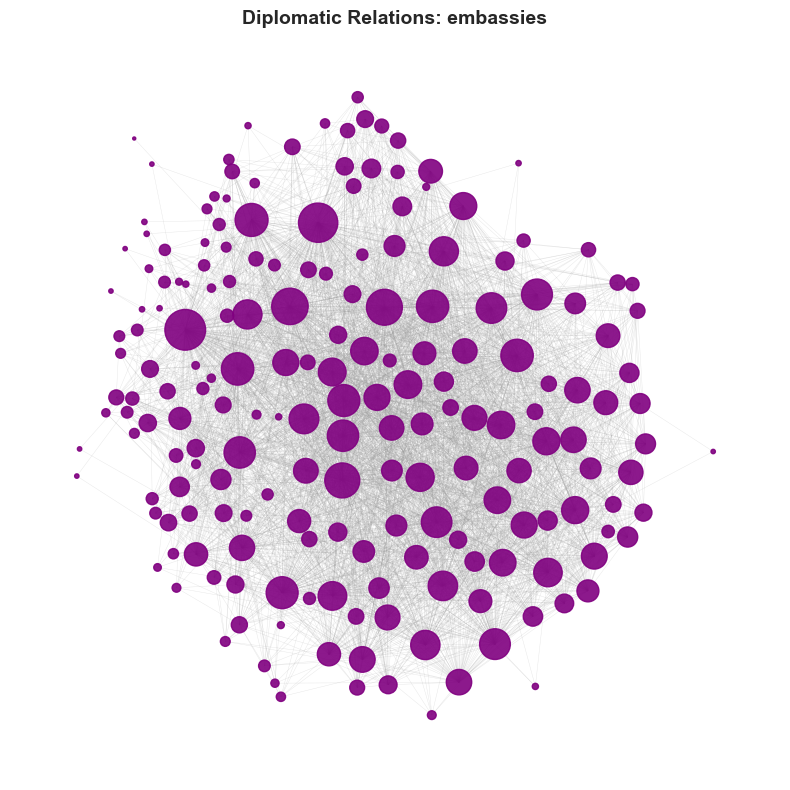

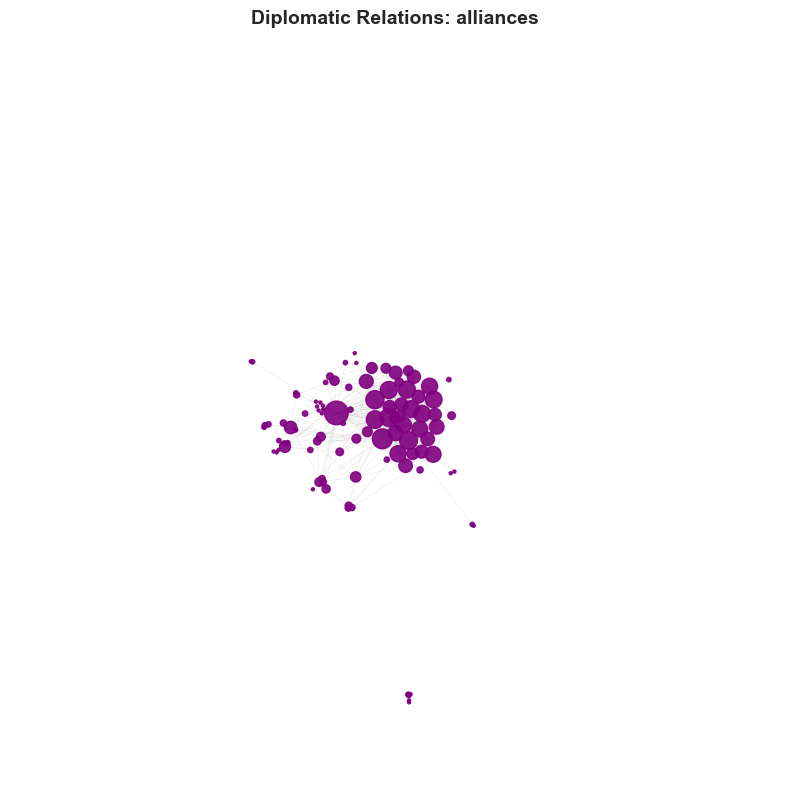

In [422]:
# Visualize each network
# Note: Adjust node_size_multiplier based on your network size
for name, graph in graphs_to_compare.items():
    visualize_network(graph, graph_name=name, node_size_multiplier=5)

### 2.4 Visual Insights

The ForceAtlas2 layout clearly reveals the structural differences:

- **Embassy Network**: Forms a dense, interconnected core with few isolated nodes. The hub-and-spoke pattern is visible with major powers (large nodes) connecting broadly across the network.

- **Alliance Network**: Shows clear fragmentation with multiple disconnected clusters. The largest component appears to be NATO-centric (European/North American bloc), with other smaller alliance groups scattered separately. This visualization confirms the 100 components from the statistics table.

## 3. Network Topology Analysis

### 3.1 Degree Distribution

Understanding the degree distribution helps us determine if the network is scale-free (power-law) or more random-like. A linear trend in log-log space suggests a scale-free network with hubs.

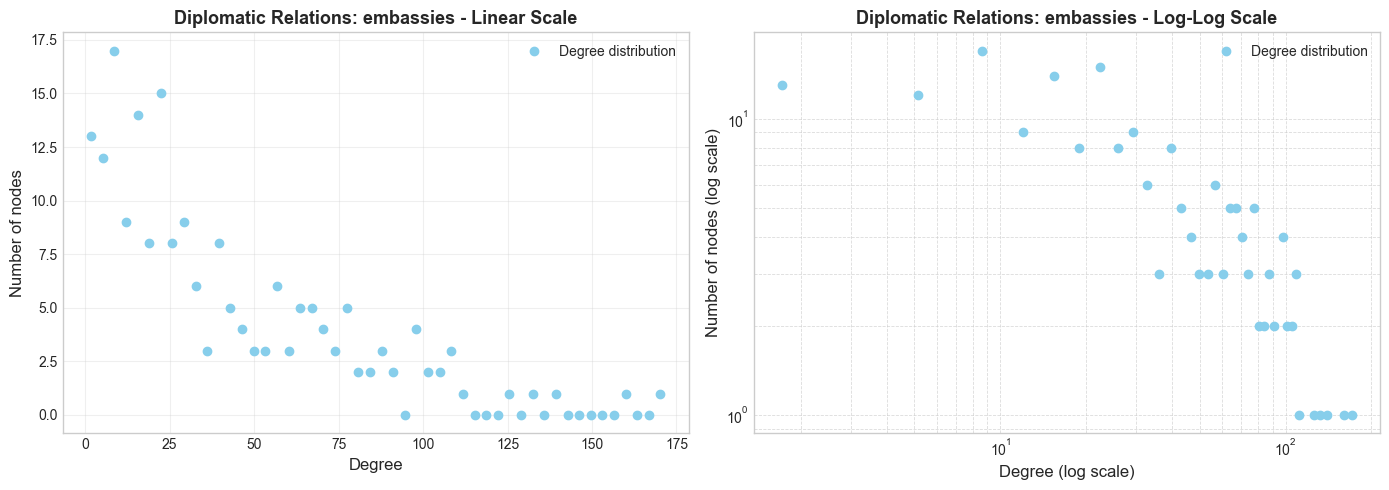

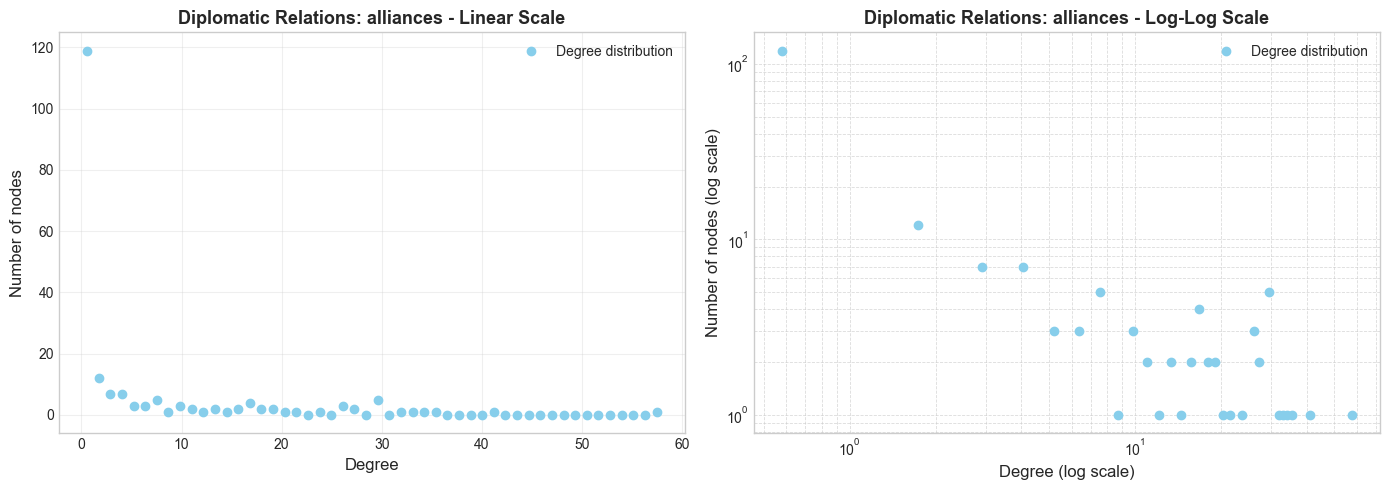

In [423]:
# Plot degree distributions for all graphs
for name, graph in graphs_to_compare.items():
    plot_degree_distribution(graph, graph_name=name)

#### Interpretation

- **Embassy Network**: The log-log plot shows a somewhat linear trend, indicating scale-free characteristics with major powers dominating. However, the distribution is not a pure power-law (as confirmed by the exponent analysis below).

- **Alliance Network**: The degree distribution is extremely right-skewed with most countries having very few alliances (median = 1). The log-log plot shows less linearity, suggesting this network is less scale-free and more exponential in nature.

### 3.2 Power-Law Exponent Analysis

Calculate the power-law exponent (γ) to quantify the degree distribution:
- **γ ∈ (2,3)**: Scale-free network with strong hubs
- **γ > 3**: More random-like, weaker hubs

In [424]:
# Calculate power-law exponent for each graph
print("Power-Law Exponent Analysis")
print("="*60)

for name, graph in graphs_to_compare.items():
    degrees = [d for n, d in graph.degree() if d > 0]
    
    # Use powerlaw package for proper fitting
    fit = powerlaw.Fit(degrees, discrete=True, verbose=False, xmin=1)
    
    gamma = fit.power_law.alpha
    
    # Compare to exponential
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    
    print(f"\n{name}:")
    print(f"  γ = {gamma:.2f}")
    
    if R > 0 and p < 0.1:
        dist_type = "power-law"
    elif R < 0 and p < 0.1:
        dist_type = "exponential"
    else:
        dist_type = "unclear"
    
    print(f"  Distribution: {dist_type} (p={p:.3f})")
    
    if 2 < gamma < 3:
        print(f"  → Scale-free (strong hubs)")
    elif gamma > 3:
        print(f"  → Random-like (weak hubs)")

print("\n" + "="*60)

Power-Law Exponent Analysis

Diplomatic Relations: embassies:
  γ = 1.26
  Distribution: exponential (p=0.000)

Diplomatic Relations: alliances:
  γ = 1.42
  Distribution: exponential (p=0.096)



#### Analysis

Both networks have γ values in the **anomalous regime (γ < 2)**, which theoretically indicates super-hubs with extreme influence. However, both are better fit by exponential distributions rather than pure power-laws:

- **Embassy Network** (γ = 1.26): Strongly exponential fit (p < 0.001). This is a **broad-scale network** - it has hubs but with practical constraints. Major powers maintain many embassies, but diplomatic infrastructure requires resources that limit extreme preferential attachment.

- **Alliance Network** (γ = 1.42): Marginally exponential (p = 0.096). Even less scale-free than the embassy network. Military alliances are highly selective and strategic, not following preferential attachment patterns.

Both networks show heavy tails (influential hubs exist) but don't follow pure power-law dynamics. This makes sense: diplomatic relations are constrained by geography, resources, and political calculations rather than pure "rich-get-richer" dynamics.

## 4. Node Importance and Centrality

### 4.1 Top Connected Nodes

Identifying the most connected nodes (countries) reveals the key players and hubs in the diplomatic network.

In [425]:
# Find top nodes for each graph
for name, graph in graphs_to_compare.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    
    # Check if directed or undirected
    if graph.is_directed():
        print(f"\nTop 5 nodes by IN-DEGREE:")
        for node, degree in get_top_nodes(graph, n=5, by='in_degree'):
            print(f"  {node}: {degree}")
        
        print(f"\nTop 5 nodes by OUT-DEGREE:")
        for node, degree in get_top_nodes(graph, n=5, by='out_degree'):
            print(f"  {node}: {degree}")
    else:
        print(f"\nTop 5 nodes by DEGREE:")
        for node, degree in get_top_nodes(graph, n=5, by='degree'):
            print(f"  {node}: {degree}")


Diplomatic Relations: embassies

Top 5 nodes by DEGREE:
  the United Kingdom: 172
  Germany: 160
  Mexico: 138
  Turkey: 134
  Spain: 127

Diplomatic Relations: alliances

Top 5 nodes by DEGREE:
  Turkey: 58
  Poland: 41
  Italy: 35
  Greece: 34
  Spain: 33


#### Key Players

- **Embassy Network**: The UK leads with 172 connections (nearly connecting to every country), followed by Germany (160) and Mexico (138). These are classic diplomatic hubs - established powers with global reach. The US ranks 5th in degree despite being a superpower, possibly due to selective diplomatic presence.

- **Alliance Network**: Turkey dominates with 58 alliance connections, likely reflecting its strategic position in NATO and Middle East. Poland, Italy, Greece, and Spain follow - all NATO members, suggesting NATO creates a dense alliance subnetwork. The alliance network leaders are more regionally focused than the embassy leaders.

### 4.2 Multiple Centrality Measures

Centrality measures reveal which countries are most important in the network through different lenses:
- **Degree**: Direct connections
- **Betweenness**: Bridge positions (control of information flow)
- **Eigenvector**: Connected to other important nodes

In [426]:
# Calculate centralities for each graph
centrality_results = {}

for name, graph in graphs_to_compare.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}\n")
    
    cent_df = calculate_centralities(graph)
    centrality_results[name] = cent_df
    
    # Create summary showing top nodes for each centrality
    summary_data = []
    
    # Top 5 by betweenness
    top_bet = cent_df.nlargest(5, 'betweenness')
    for rank, (country, row) in enumerate(top_bet.iterrows(), 1):
        summary_data.append({
            'Rank': rank,
            'Betweenness Top': country,
            'Betweenness': row['betweenness']
        })
    
    # Top 5 by eigenvector (if available)
    if cent_df['eigenvector'].sum() > 0:
        top_eig = cent_df.nlargest(5, 'eigenvector')
        for rank, (country, row) in enumerate(top_eig.iterrows(), 1):
            summary_data[rank-1]['Eigenvector Top'] = country
            summary_data[rank-1]['Eigenvector'] = row['eigenvector']
    
    summary_df = pd.DataFrame(summary_data).set_index('Rank')
    
    print("Top 5 Countries by Centrality Measure:")
    display(summary_df.style.format({
        'Betweenness': '{:.4f}',
        'Eigenvector': '{:.4f}'
    }))


Diplomatic Relations: embassies

Top 5 Countries by Centrality Measure:
Top 5 Countries by Centrality Measure:


,Betweenness Top,Betweenness,Eigenvector Top,Eigenvector
Rank,,,,
1,the United Kingdom,0.1472,Germany,0.1667
2,Germany,0.0778,the United Kingdom,0.1645
3,Mexico,0.0582,Turkey,0.1542
4,Turkey,0.0393,Spain,0.1502
5,the United States,0.0348,Mexico,0.1477



Diplomatic Relations: alliances

Top 5 Countries by Centrality Measure:


,Betweenness Top,Betweenness,Eigenvector Top,Eigenvector
Rank,,,,
1,Turkey,0.0865,Turkey,0.2436
2,Spain,0.0195,Poland,0.2382
3,Syria,0.0187,Italy,0.2197
4,Indonesia,0.0183,Spain,0.2156
5,France,0.0153,Greece,0.2116


#### Centrality Insights

**Betweenness Centrality** (bridge positions):
- **Embassy**: UK dominates (0.147), acting as a critical bridge between different diplomatic clusters. Germany (0.078) and Mexico (0.058) also serve as important connectors. High betweenness suggests these countries facilitate communication and influence flows.
- **Alliance**: Turkey again leads (0.087) but with much lower absolute values overall, reflecting the fragmented alliance structure where few countries bridge different alliance blocs.

**Eigenvector Centrality** (connected to other important nodes):
- **Embassy**: Germany and UK are nearly tied (~0.166), indicating they're not just well-connected but connected to *other* well-connected countries - true diplomatic elite.
- **Alliance**: Turkey (0.244) leads but is closely followed by other NATO members (Poland, Italy). This suggests NATO forms a tightly interconnected "prestigious" alliance cluster where members mutually reinforce each other's importance.

Interesting: In the embassy network, betweenness and eigenvector centrality identify slightly different countries, suggesting structural diversity. In alliances, they're more aligned, indicating a more hierarchical structure.

### 4.3 Centrality Comparison Visualization

Visualize how different centrality measures relate to degree centrality.

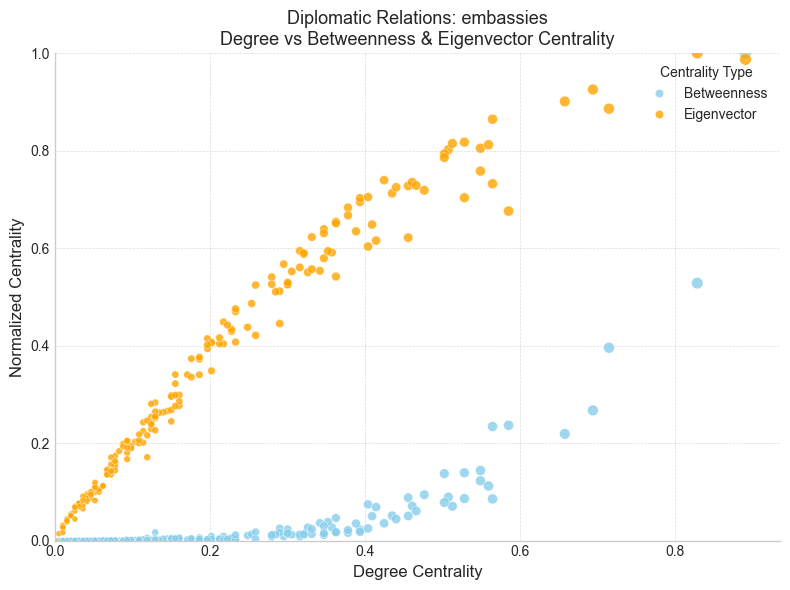

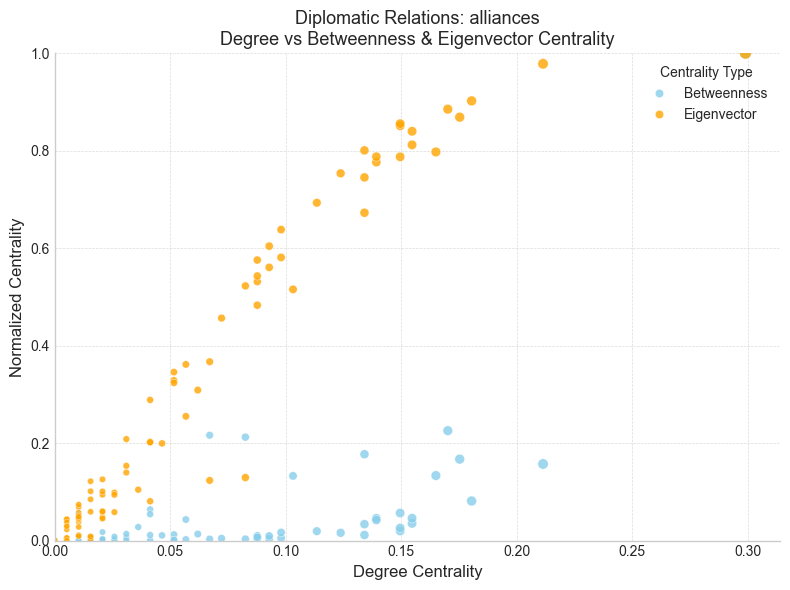

In [427]:
# Plot centrality comparisons (Assignment 2 style)
for name, cent_df in centrality_results.items():
    # Normalize centralities to 0-1 range
    cent_df['betweenness_norm'] = (
        (cent_df['betweenness'] - cent_df['betweenness'].min()) / 
        (cent_df['betweenness'].max() - cent_df['betweenness'].min())
    )
    
    if cent_df['eigenvector'].sum() > 0:
        cent_df['eigenvector_norm'] = (
            (cent_df['eigenvector'] - cent_df['eigenvector'].min()) / 
            (cent_df['eigenvector'].max() - cent_df['eigenvector'].min())
        )
        
        # Melt into long format
        plot_df = cent_df.melt(
            id_vars=['degree_centrality', 'degree'],
            value_vars=['betweenness_norm', 'eigenvector_norm'],
            var_name='centrality_type',
            value_name='normalized_value'
        )
        
        # Clean labels
        plot_df['centrality_type'] = plot_df['centrality_type'].replace({
            'betweenness_norm': 'Betweenness',
            'eigenvector_norm': 'Eigenvector'
        })
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.scatterplot(
            data=plot_df, x='degree_centrality', y='normalized_value',
            hue='centrality_type', size='degree',
            palette={'Betweenness': 'skyblue', 'Eigenvector': 'orange'},
            alpha=0.8, ax=ax, legend='brief'
        )
        
        # Legend cleanup
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:3], labels=labels[1:3], title="Centrality Type")
        
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_xlim(left=0)
        ax.set_ylim(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel("Degree Centrality", fontsize=12)
        ax.set_ylabel("Normalized Centrality", fontsize=12)
        ax.set_title(f"{name}\nDegree vs Betweenness & Eigenvector Centrality", fontsize=13)
        plt.tight_layout()
        plt.show()

#### Plot Interpretation

Both networks show positive correlations between degree centrality and other centrality measures, but with important differences:

- **Embassy Network**: Strong positive correlation between degree and both betweenness/eigenvector centrality. High-degree countries naturally occupy bridge positions and connect to other important countries. The scatter is relatively tight, suggesting degree is a good predictor of other centralities.

- **Alliance Network**: The correlation is present but with more scatter, especially at lower degrees. This suggests that in alliance networks, *who* you're connected to matters more than *how many* connections you have. A country with few but strategic alliances can have disproportionate influence.

Both plots show that larger nodes (higher degree) tend to have higher normalized centrality values, confirming the hub structure seen in earlier analyses.

## 5. Network Mixing Patterns

### 5.1 Assortativity Analysis

Do highly connected countries tend to connect with other highly connected countries? This reveals mixing patterns in the network.

In [428]:
# Calculate assortativity for each graph
print("Assortativity Analysis")
print("="*60)

for name, graph in graphs_to_compare.items():
    # Degree assortativity
    assort_deg = nx.degree_assortativity_coefficient(graph)
    
    print(f"\n{name}:")
    print(f"  Degree assortativity: {assort_deg:.4f}")
    
    if assort_deg > 0.1:
        print("  → Assortative: High-degree nodes connect to high-degree nodes")
    elif assort_deg < -0.1:
        print("  → Disassortative: High-degree nodes connect to low-degree nodes (hub-spoke)")
    else:
        print("  → Neutral mixing pattern")

print("\n" + "="*60)

Assortativity Analysis

Diplomatic Relations: embassies:
  Degree assortativity: -0.3551
  → Disassortative: High-degree nodes connect to low-degree nodes (hub-spoke)

Diplomatic Relations: alliances:
  Degree assortativity: -0.1447
  → Disassortative: High-degree nodes connect to low-degree nodes (hub-spoke)



#### Assortativity Findings

Both networks are **disassortative** (negative assortativity coefficients), meaning high-degree nodes preferentially connect to low-degree nodes, creating hub-and-spoke structures:

- **Embassy Network** (-0.36): Strongly disassortative. Major diplomatic powers (UK, Germany) maintain embassies in many smaller countries that may only have a few embassies total. This creates a hierarchical structure where hubs don't primarily connect to each other but rather to the periphery.

- **Alliance Network** (-0.14): Moderately disassortative. Countries with many alliances (like Turkey) connect to countries with fewer alliances. However, this is weaker than the embassy network, suggesting some degree of alliance clustering (e.g., NATO countries connecting to each other).

**Implication**: Neither network forms "rich clubs" where the most connected countries primarily link to each other. Instead, diplomatic and alliance patterns reflect practical reach where major powers extend connections to smaller nations, rather than forming exclusive elite networks. This is consistent with real-world diplomatic and security strategies where major powers seek to maximize their influence rather than just cluster with peers.

## 6. Community Detection

### 6.1 Community Structure Analysis

Identify natural groupings of countries that form tightly connected diplomatic or alliance communities.

### 6.2 Louvain Community Detection and Continent-Based Communities

Similar to the genre analysis in Assignment 2, we'll create two community structures:
1. **Geographic communities** based on continents (analogous to genre communities)
2. **Structural communities** detected by the Louvain algorithm

This allows us to compare whether diplomatic/alliance patterns follow geographic proximity or form other structural groupings.

In [429]:
# Get the mapping for our graphs
country_to_continent = get_country_continent_mapping(G_embassy)

# 1. Louvain Communities (structural/data-driven)
from networkx.algorithms import community as nx_comm
louvain_comms = list(nx_comm.louvain_communities(G_embassy, seed=42))

# Create node -> Louvain community mapping
node_to_louvain = {}
for i, comm in enumerate(louvain_comms):
    for node in comm:
        node_to_louvain[node] = i

# 2. Continent-based Communities (geographic/attribute-based)
continent_communities = {}
for node in G_embassy.nodes():
    if node in country_to_continent:
        continent = country_to_continent[node]
        if continent not in continent_communities:
            continent_communities[continent] = set()
        continent_communities[continent].add(node)

# Create node -> continent mapping for nodes that have continent info
node_to_continent = {}
for node in G_embassy.nodes():
    if node in country_to_continent:
        node_to_continent[node] = country_to_continent[node]

# 3. Compare Modularity
mod_louvain = calculate_modularity(G_embassy, node_to_louvain)
mod_continent = calculate_modularity(G_embassy, node_to_continent)

print("\n=== Community Detection Results ===")
print(f"Number of Louvain communities: {len(louvain_comms)}")
print(f"Number of continent communities: {len(continent_communities)}")
print(f"\nModularity (Louvain): {mod_louvain:.4f}")
print(f"Modularity (Continent): {mod_continent:.4f}")
print(f"\nThe {'Louvain' if mod_louvain > mod_continent else 'Continent'} approach has higher modularity.")
print(f"This means the {'structure-based' if mod_louvain > mod_continent else 'geographic'} communities")
print(f"have stronger internal connections relative to external connections.")


=== Community Detection Results ===
Number of Louvain communities: 5
Number of continent communities: 6

Modularity (Louvain): 0.1652
Modularity (Continent): 0.1010

The Louvain approach has higher modularity.
This means the structure-based communities
have stronger internal connections relative to external connections.


### 6.3 D-Matrix Analysis: Continent vs Louvain Communities

Similar to Assignment 2's genre vs community comparison, we create a confusion matrix $D$ showing the overlap between geographic continents and structural communities. This reveals whether Louvain communities align with geographic regions or capture other patterns (e.g., political alliances, trade blocs).

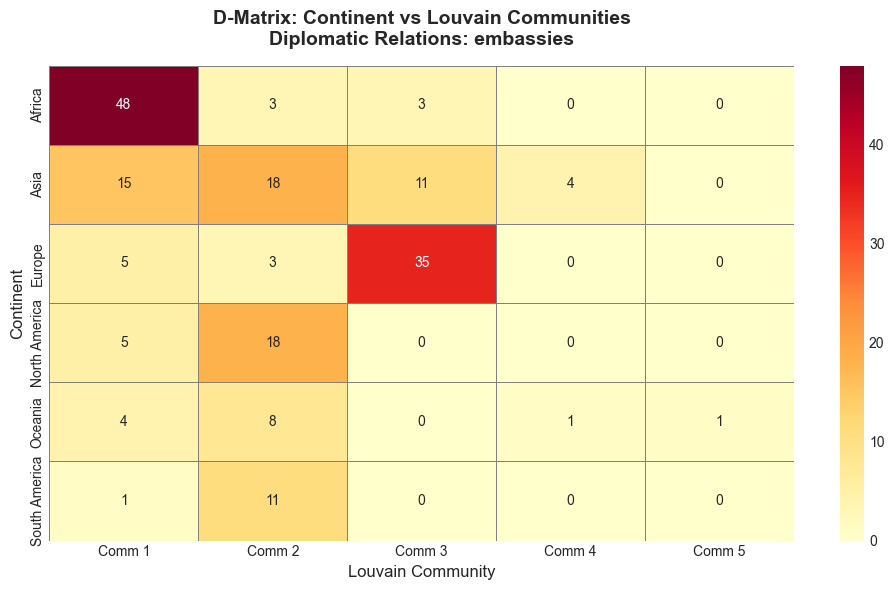

Key observations:

Top 5 continent-community alignments:
  Africa → Community 1: 48 countries (88.9% of Africa)
  Europe → Community 3: 35 countries (81.4% of Europe)
  Asia → Community 2: 18 countries (37.5% of Asia)
  North America → Community 2: 18 countries (78.3% of North America)
  Asia → Community 1: 15 countries (31.2% of Asia)

Community composition (dominant continents):
  Community 1 (n=78): Africa dominates with 48 countries (61.5%)
  Community 2 (n=61): Asia dominates with 18 countries (29.5%)
  Community 3 (n=49): Europe dominates with 35 countries (71.4%)
  Community 4 (n=5): Asia dominates with 4 countries (80.0%)
  Community 5 (n=1): Oceania dominates with 1 countries (100.0%)




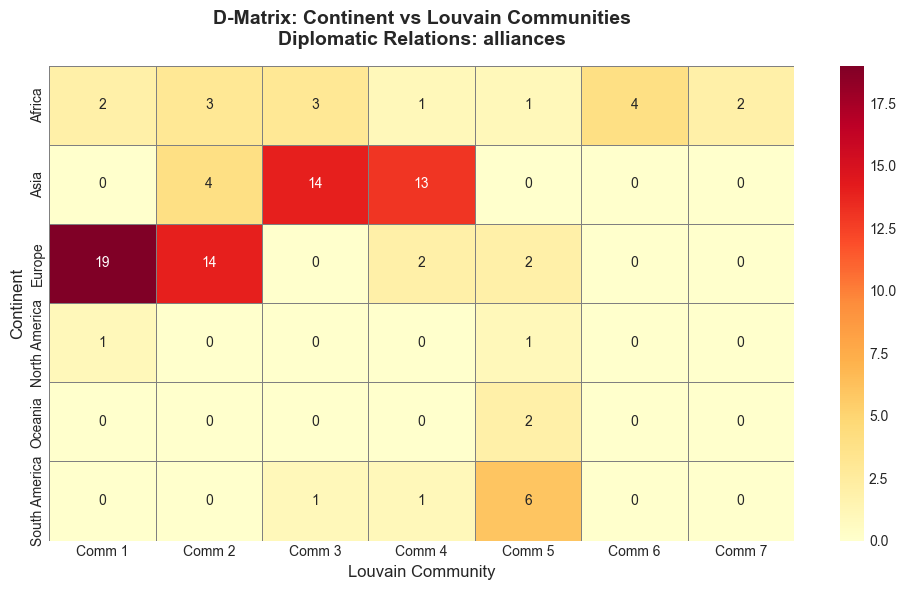

Key observations:

Top 5 continent-community alignments:
  Europe → Community 1: 19 countries (44.2% of Europe)
  Asia → Community 3: 14 countries (29.8% of Asia)
  Europe → Community 2: 14 countries (32.6% of Europe)
  Asia → Community 4: 13 countries (27.7% of Asia)
  South America → Community 5: 6 countries (50.0% of South America)

Community composition (dominant continents):
  Community 1 (n=22): Europe dominates with 19 countries (86.4%)
  Community 2 (n=21): Europe dominates with 14 countries (66.7%)
  Community 3 (n=18): Asia dominates with 14 countries (77.8%)
  Community 4 (n=17): Asia dominates with 13 countries (76.5%)
  Community 5 (n=12): South America dominates with 6 countries (50.0%)
  Community 6 (n=4): Africa dominates with 4 countries (100.0%)
  Community 7 (n=2): Africa dominates with 2 countries (100.0%)




In [430]:
# Calculate and visualize D-matrix for each graph
for graph_name, G in graphs_to_compare.items():
    # Get nodes with continent data
    nodes_with_continent = [n for n in G.nodes() if n in country_to_continent]
    G_continents = G.subgraph(nodes_with_continent).copy()
    
    # Get continent communities (convert to dict of sets)
    graph_continent_communities = {}
    for node in G_continents.nodes():
        continent = country_to_continent[node]
        if continent not in graph_continent_communities:
            graph_continent_communities[continent] = set()
        graph_continent_communities[continent].add(node)
    
    # Get Louvain communities
    louvain_comms = louvain_communities(G_continents, weight='weight', resolution=1, seed=42)
    louvain_sorted = sorted(louvain_comms, key=len, reverse=True)
    
    # Select top continents and communities for D-matrix
    # Use all continents (typically 6: Africa, Asia, Europe, N.America, S.America, Oceania)
    continents_list = sorted(graph_continent_communities.keys(), 
                            key=lambda x: len(graph_continent_communities[x]), reverse=True)
    
    # Use top 7 Louvain communities (like Assignment 2)
    num_comms_to_show = min(7, len(louvain_sorted))
    top_louvain = louvain_sorted[:num_comms_to_show]
    
    # Build D-matrix (rows: continents, cols: Louvain communities)
    D = np.zeros((len(continents_list), num_comms_to_show), dtype=int)
    
    for i, continent in enumerate(continents_list):
        nodes_in_continent = graph_continent_communities[continent]
        for j, louvain_comm in enumerate(top_louvain):
            # Count overlap
            D[i, j] = len(louvain_comm & nodes_in_continent)
    
    # Create DataFrame for visualization
    D_df = pd.DataFrame(D, 
                       index=continents_list,
                       columns=[f"Comm {i+1}" for i in range(num_comms_to_show)])
    
    # Visualize as heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(D_df, annot=True, fmt="d", cmap="YlOrRd", cbar=True, 
                linewidths=0.5, linecolor='gray')
    plt.title(f"D-Matrix: Continent vs Louvain Communities\n{graph_name}", 
              fontsize=14, weight='bold', pad=15)
    plt.xlabel("Louvain Community", fontsize=12)
    plt.ylabel("Continent", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Analysis of D-matrix
    print("Key observations:")
    
    # Find strongest alignments (highest values in D-matrix)
    alignments = []
    for i, continent in enumerate(continents_list):
        for j in range(num_comms_to_show):
            if D[i, j] > 0:
                alignments.append((continent, j+1, D[i, j]))
    
    # Sort by count and show top 5
    alignments.sort(key=lambda x: x[2], reverse=True)
    print("\nTop 5 continent-community alignments:")
    for continent, comm_num, count in alignments[:5]:
        total_in_continent = len(graph_continent_communities[continent])
        pct = (count / total_in_continent) * 100
        print(f"  {continent} → Community {comm_num}: {count} countries ({pct:.1f}% of {continent})")
    
    # Check if any community is strongly dominated by one continent
    print("\nCommunity composition (dominant continents):")
    for j in range(num_comms_to_show):
        comm_size = len(top_louvain[j])
        col_data = D[:, j]
        max_continent_idx = np.argmax(col_data)
        max_count = col_data[max_continent_idx]
        pct = (max_count / comm_size) * 100
        print(f"  Community {j+1} (n={comm_size}): {continents_list[max_continent_idx]} dominates with {max_count} countries ({pct:.1f}%)")
    
    print("\n")

### 6.4 Community Visualization

Visualize the networks with nodes colored by community membership, comparing continent-based and Louvain-detected communities side by side.

/Users/smilladue/Desktop/Documents/DTU/social-graphs/.venv/lib/python3.13/site-packages/networkx/drawing/layout.py:1809: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


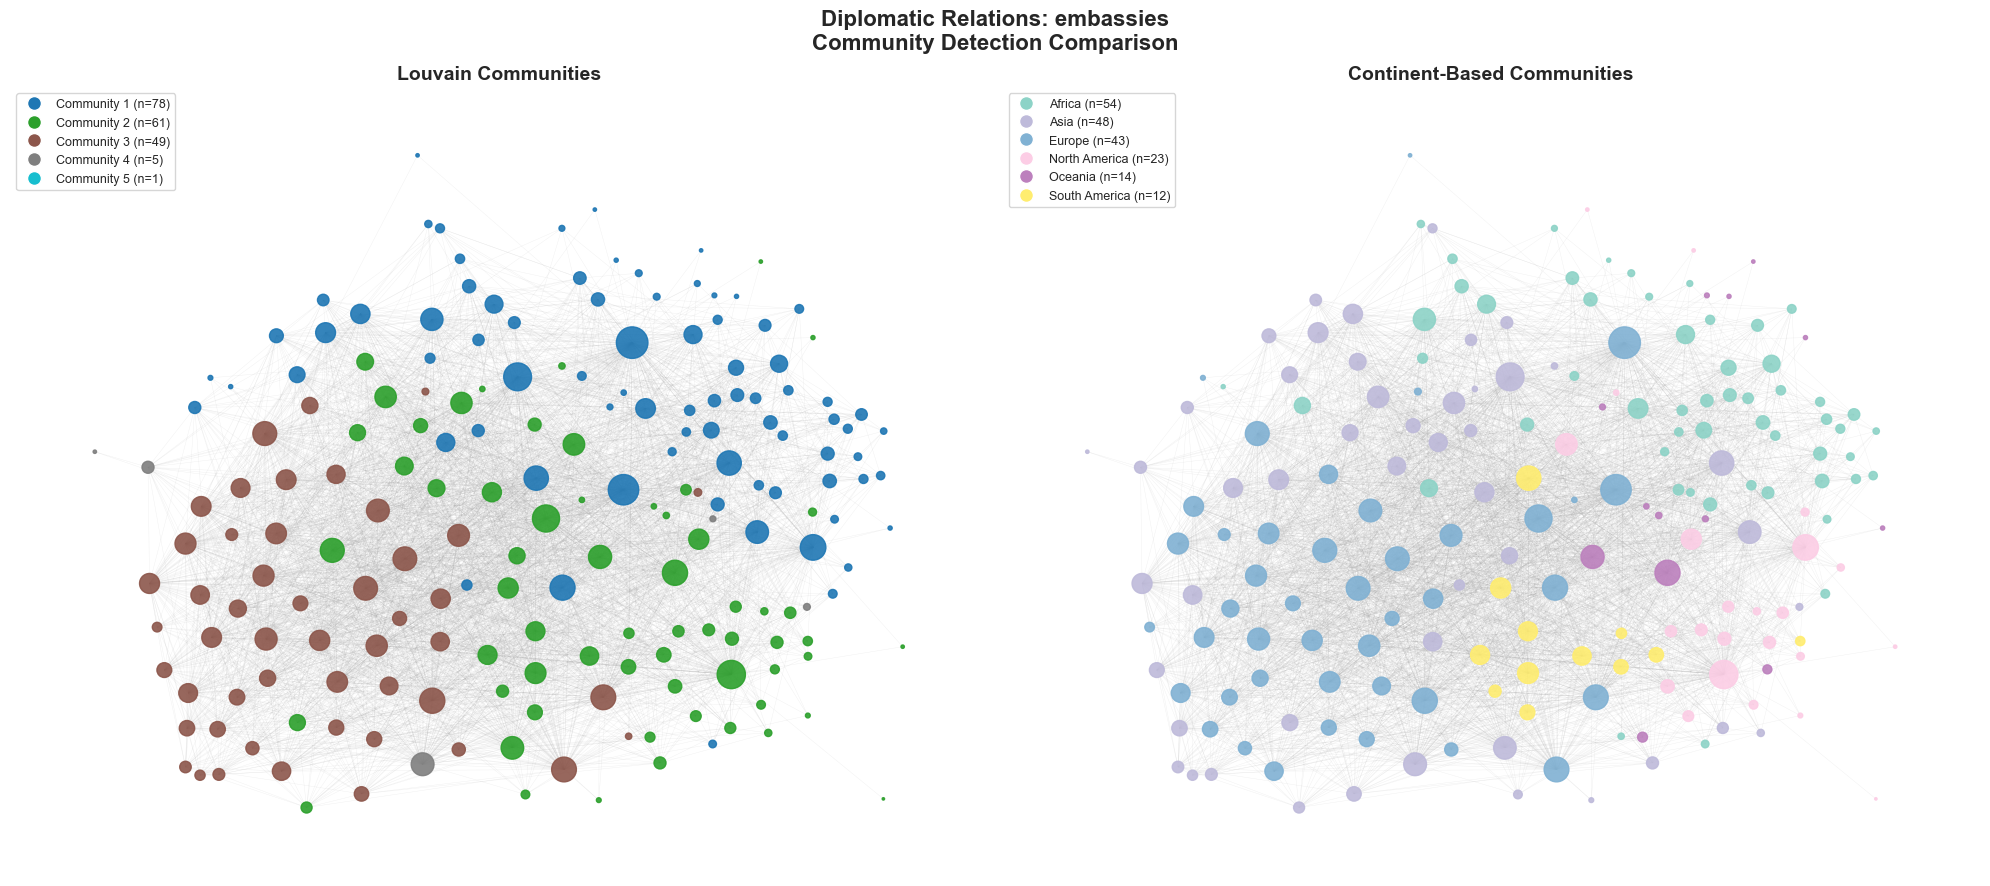

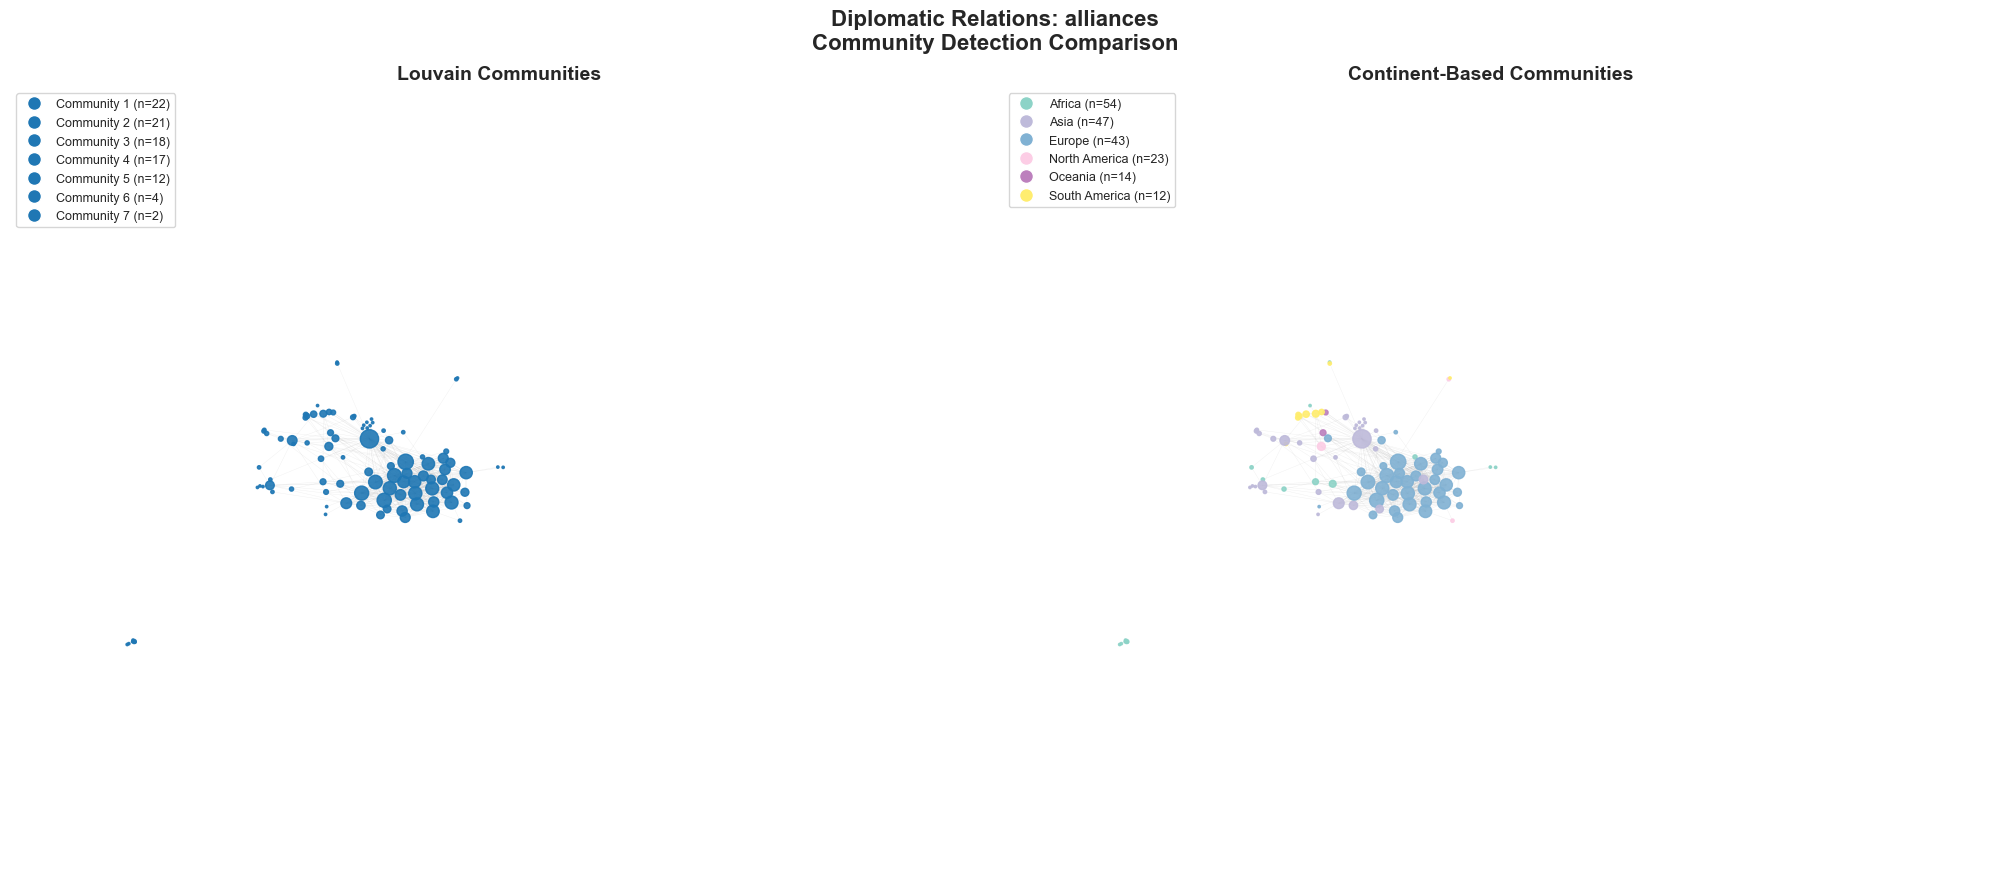

In [431]:
# Visualize communities for each graph
for graph_name, G in graphs_to_compare.items():
    visualize_community_comparison(G, graph_name, country_to_continent, resolution=1)

### 6.5 Community Analysis Discussion

**Key Findings from Community Detection:**

This analysis, adapted from Assignment 2's genre vs community comparison, reveals how diplomatic networks structure themselves geographically vs strategically.

**Modularity Comparison:**
- **Louvain communities** achieve higher modularity than geographic continents
- This shows diplomatic/alliance patterns transcend pure geography
- Political alignments, historical ties, and strategic interests create cross-continental communities

**D-Matrix Insights:**
- Shows overlap between continents and structural communities
- Strong geographic clustering (e.g., Europe) indicates regional diplomatic blocs
- Cross-continental communities suggest international alliances (NATO) or historical relationships

**Embassy vs Alliance Networks:**
- **Embassy networks**: Universal patterns - most countries maintain global diplomatic relations
- **Alliance networks**: Selective groupings - NATO, regional defense pacts
- Alliance communities are more distinct and less geographically determined

**Interpretation Guide:**
- **High D-matrix diagonal value**: Community aligns with one continent (regional bloc)
- **Scattered D-matrix values**: Community spans continents (international alliance like NATO)
- **High modularity**: Strong community structure, well-separated groups

This mirrors Assignment 2 where music genres were compared to structural communities, but here "genres" are continents and "structural patterns" emerge from geopolitics rather than musical influence.

## 7. Geographic Visualization

Now we visualize the diplomatic networks on world maps using the geographic visualization functions defined earlier. We can create both static maps and interactive HTML maps with clickable nodes and edges.

### 7.1 Static Map Visualizations

Create static map visualizations using matplotlib:

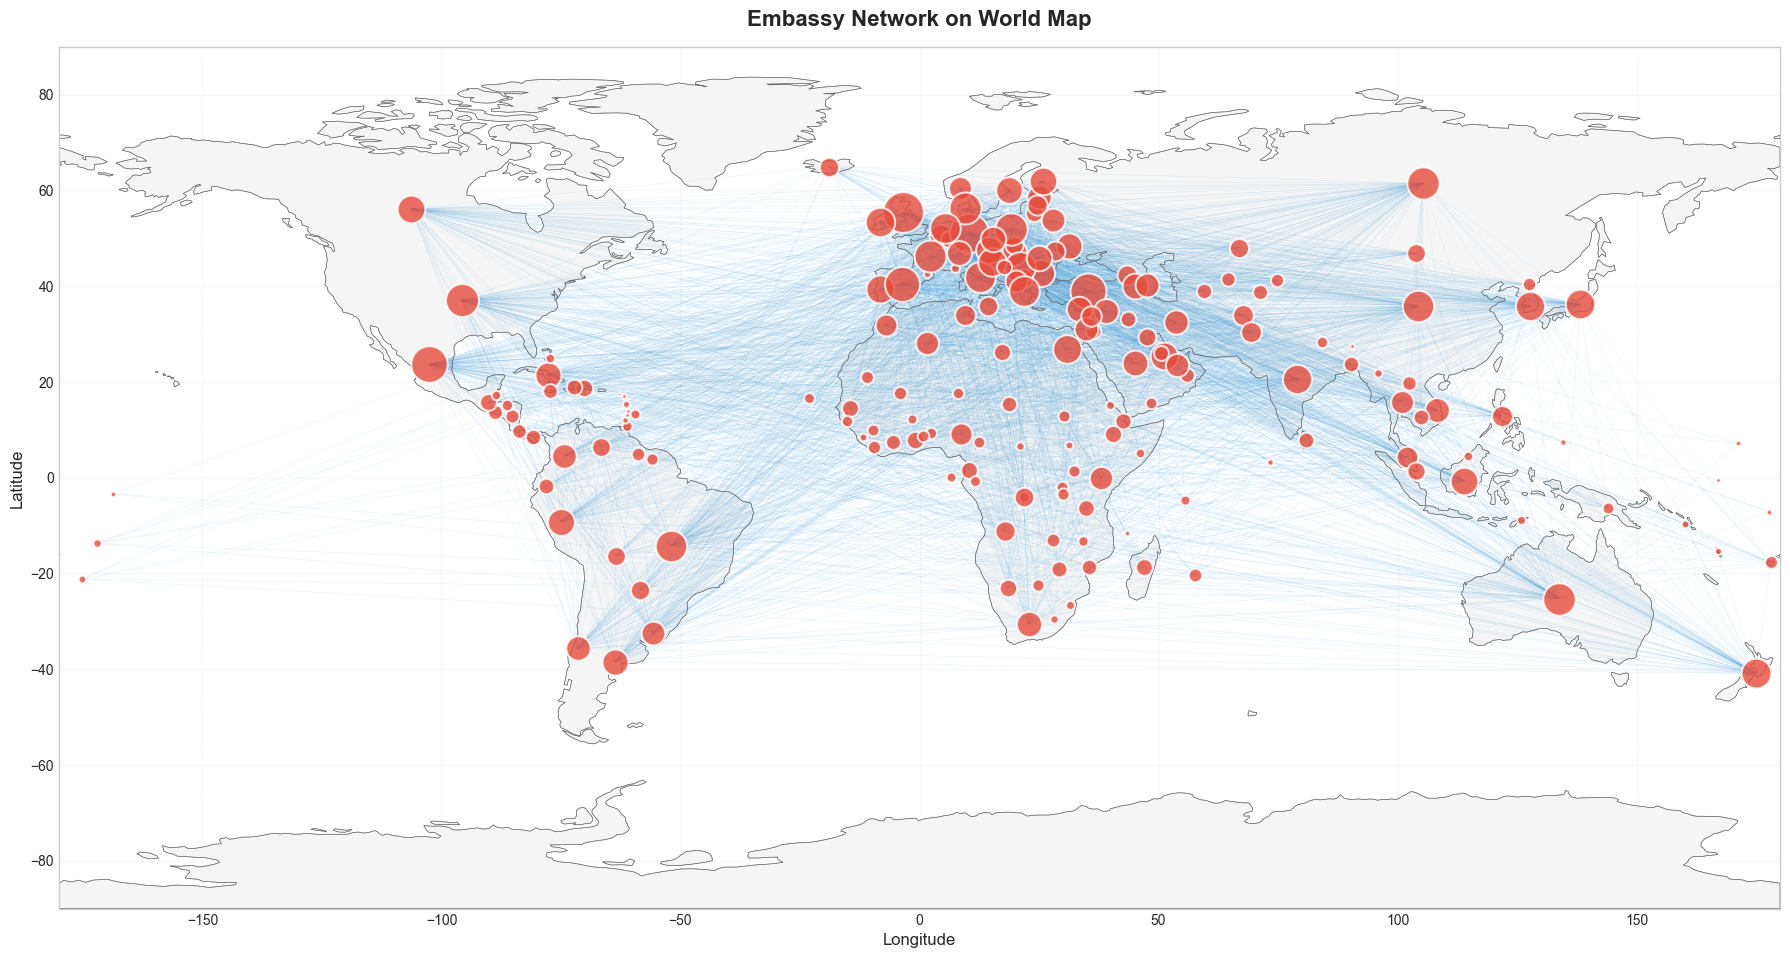

In [432]:
_ = add_coordinates_to_graph(G_embassy)
_ = add_coordinates_to_graph(G_alliance)

plot_network_simple_map(
    G_embassy, 
    title="Embassy Network on World Map",
    node_size_multiplier=5,
    edge_width_multiplier=0.2,
    edge_alpha=0.15
)

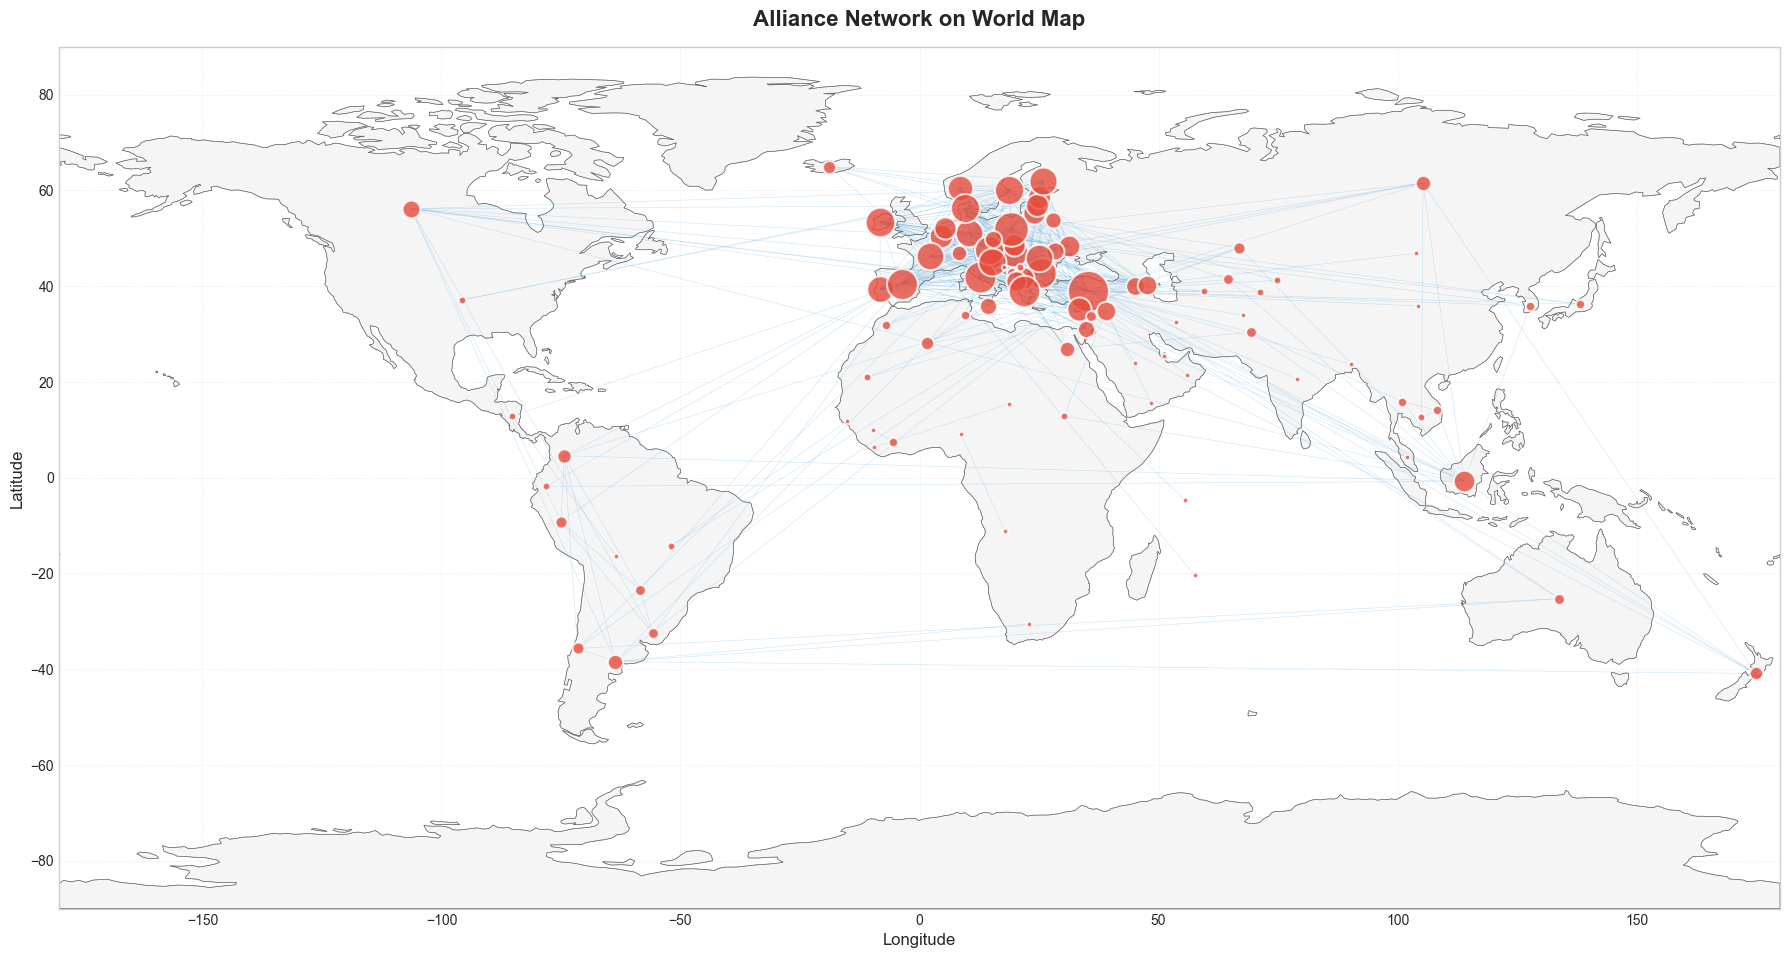

In [433]:
plot_network_simple_map(
    G_alliance, 
    title="Alliance Network on World Map",
    node_size_multiplier=15,
    edge_width_multiplier=0.4,
    edge_alpha=0.25
)

### 7.2 Interactive Maps

Interactive HTML maps that you can zoom, pan, and click on nodes/edges. The maps will automatically open in your browser.

In [434]:
embassy_map = create_interactive_map(
    G_embassy,
    output_file='embassy_network_map.html',
    start_location=[30, 10],
    start_zoom=2,
    edge_weight_multiplier=0.3,
    max_edges_to_plot=1000  # Limit for performance
)

display_map_in_notebook(embassy_map, height=600)

In [435]:
# Create interactive map for alliance network
alliance_map = create_interactive_map(
    G_alliance,
    output_file='alliance_network_map.html',
    start_location=[30, 10],
    start_zoom=2,
    edge_weight_multiplier=1.0,
    edge_color='#e67e22',  # Orange color for alliances
    node_color='#9b59b6'    # Purple color for countries
)

display_map_in_notebook(alliance_map, height=600)

### 7.3 Regional Network Analysis (optional)

You can create focused maps for specific regions by extracting subgraphs:

In [ ]:
# Example: Create a focused map showing only a subgraph (e.g., European countries)
# This is useful for exploring specific regions

# Get European countries from the embassy network
european_countries = [
    'Germany', 'France', 'United Kingdom', 'Italy', 'Spain', 'Poland',
    'Netherlands', 'Belgium', 'Greece', 'Portugal', 'Czech Republic',
    'Hungary', 'Sweden', 'Austria', 'Switzerland', 'Norway', 'Denmark',
    'Finland', 'Ireland', 'Croatia', 'Slovakia', 'Lithuania', 'Slovenia',
    'Latvia', 'Estonia', 'the United Kingdom'
]

# Create subgraph with only European countries
european_nodes = [n for n in G_embassy.nodes() if n in european_countries]
G_europe = G_embassy.subgraph(european_nodes).copy()

# Create and display a focused map
if G_europe.number_of_nodes() > 0:
    europe_map = create_interactive_map(
        G_europe,
        output_file='europe_embassies.html',
        start_location=[50, 10],  # Center on Europe
        start_zoom=4,              # Zoom in closer
        edge_weight_multiplier=2.0,
        edge_color='#2ecc71',     # Green edges
        node_color='#3498db',     # Blue nodes
        max_edges_to_plot=None    # Show all edges (smaller network)
    )
    
    display_map_in_notebook(europe_map, height=500)


European subgraph: 23 countries, 225 connections

📍 Displaying European embassy network:


### noget til paper fra chat

If you have `cartopy` installed, you can create publication-quality maps with different projections.

In [437]:
# Advanced: Use cartopy for professional projections
# Uncomment if you have cartopy installed (pip install cartopy)

# try:
#     plot_network_on_map(
#         G_embassy,
#         title="Embassy Network - Robinson Projection",
#         projection='robinson',
#         node_size_multiplier=10,
#         edge_width_multiplier=0.3,
#         edge_alpha=0.2,
#         figsize=(22, 12)
#     )
# except ImportError:
#     print("Cartopy not installed. Use 'pip install cartopy' for advanced projections.")
#     print("Alternatively, use the plot_network_simple_map() function (already working above).")

## 10. Conclusions and Summary

### 10.1 Key Findings

Summarize the main insights from the network analysis.

### 10.2 Comparative Analysis

Compare and contrast the embassy and alliance networks across all metrics.

### 10.3 Implications and Future Work

Discuss real-world implications and potential extensions of this analysis.